In [229]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

    # Import the function from season_utils
from src.data_processing.season_utils import get_season_for_date

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

In [230]:
# Get all csv files starting with 'g_15' in data directory
data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_7-5') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [231]:
# Check for NaN values in the dataframe
print("Total NaN values in the dataframe:", processed_df.isna().sum().sum())
print("\nNaN values by column:")
nan_counts = processed_df.isna().sum()
print(nan_counts[nan_counts > 0])  # Only show columns with NaN values

# Percentage of NaN values in each column
nan_percentage = (processed_df.isna().mean() * 100).round(2)
print("\nPercentage of NaN values by column:")
print(nan_percentage[nan_percentage > 0])  # Only show columns with NaN values

Total NaN values in the dataframe: 119294

NaN values by column:
a_gp                       3
a_toi                      3
a_w                        3
a_l                        3
a_otl                      3
                        ... 
a_g_ldsv_pct_roll_std    175
a_g_rest                 173
a_g_l7                    90
h_res_dec                227
a_res_dec                236
Length: 202, dtype: int64

Percentage of NaN values by column:
a_gp                     0.03
a_toi                    0.03
a_w                      0.03
a_l                      0.03
a_otl                    0.03
                         ... 
a_g_ldsv_pct_roll_std    1.87
a_g_rest                 1.85
a_g_l7                   0.96
h_res_dec                2.42
a_res_dec                2.52
Length: 202, dtype: float64


In [232]:
# Extract the month from game_date and create a new column
processed_df['month'] = processed_df['game_date'].dt.month

# Display the first few rows to verify the new column
processed_df.tail()


,game_date,game_id,away,home,a_gp,a_toi,a_w,a_l,a_otl,a_row,a_points,a_point_pct,a_cf,a_ca,a_cf_pct,a_ff,a_fa,a_ff_pct,a_sf,a_sa,a_sf_pct,a_gf,a_ga,a_gf_pct,a_xgf,a_xga,a_xgf_pct,a_scf,a_sca,a_scf_pct,a_scsf,a_scsa,a_scsf_pct,a_scgf,a_scga,a_scgf_pct,a_scsh_pct,a_scsv_pct,a_hdcf,a_hdca,a_hdcf_pct,a_hdsf,a_hdsa,a_hdsf_pct,a_hdgf,a_hdga,a_hdgf_pct,a_hdsh_pct,a_hdsv_pct,a_mdcf,a_mdca,a_mdcf_pct,a_mdsf,a_mdsa,a_mdsf_pct,a_mdgf,a_mdga,a_mdgf_pct,a_mdsh_pct,a_mdsv_pct,a_ldcf,a_ldca,a_ldcf_pct,a_ldsf,a_ldsa,a_ldsf_pct,a_ldgf,a_ldga,a_ldgf_pct,a_ldsh_pct,a_ldsv_pct,a_sh_pct,a_sv_pct,a_pdo,a_ppgf,a_ppga,a_pp_pct,a_pkgf,a_pkga,a_pk_pct,h_gp,h_toi,h_w,h_l,h_otl,h_row,h_points,h_point_pct,h_cf,h_ca,h_cf_pct,h_ff,h_fa,h_ff_pct,h_sf,h_sa,h_sf_pct,h_gf,h_ga,h_gf_pct,h_xgf,h_xga,h_xgf_pct,h_scf,h_sca,h_scf_pct,h_scsf,h_scsa,h_scsf_pct,h_scgf,h_scga,h_scgf_pct,h_scsh_pct,h_scsv_pct,h_hdcf,h_hdca,h_hdcf_pct,h_hdsf,h_hdsa,h_hdsf_pct,h_hdgf,h_hdga,h_hdgf_pct,h_hdsh_pct,h_hdsv_pct,h_mdcf,h_mdca,h_mdcf_pct,h_mdsf,h_mdsa,h_mdsf_pct,h_mdgf,h_mdga,h_mdgf_pct,h_mdsh_pct,h_mdsv_pct,h_ldcf,h_ldca,h_ldcf_pct,h_ldsf,h_ldsa,h_ldsf_pct,h_ldgf,h_ldga,h_ldgf_pct,h_ldsh_pct,h_ldsv_pct,h_sh_pct,h_sv_pct,h_pdo,h_ppgf,h_ppga,h_pp_pct,h_pkgf,h_pkga,h_pk_pct,b2b,opp_b2b,a_goalie_name,a_goalie_id,h_goalie_name,h_goalie_id,h_g_sa_roll_avg,h_g_sa_roll_std,h_g_sv_pct_roll_avg,h_g_sv_pct_roll_std,h_g_gaa_roll_avg,h_g_gaa_roll_std,h_g_gsaa_roll_avg,h_g_gsaa_roll_std,h_g_xg_against_roll_avg,h_g_xg_against_roll_std,h_g_hd_sa_roll_avg,h_g_hd_sa_roll_std,h_g_hdsv_pct_roll_avg,h_g_hdsv_pct_roll_std,h_g_md_sa_roll_avg,h_g_md_sa_roll_std,h_g_mdsv_pct_roll_avg,h_g_mdsv_pct_roll_std,h_g_ld_sa_roll_avg,h_g_ld_sa_roll_std,h_g_ldsv_pct_roll_avg,h_g_ldsv_pct_roll_std,h_g_rest,h_g_l7,a_g_sa_roll_avg,a_g_sa_roll_std,a_g_sv_pct_roll_avg,a_g_sv_pct_roll_std,a_g_gaa_roll_avg,a_g_gaa_roll_std,a_g_gsaa_roll_avg,a_g_gsaa_roll_std,a_g_xg_against_roll_avg,a_g_xg_against_roll_std,a_g_hd_sa_roll_avg,a_g_hd_sa_roll_std,a_g_hdsv_pct_roll_avg,a_g_hdsv_pct_roll_std,a_g_md_sa_roll_avg,a_g_md_sa_roll_std,a_g_mdsv_pct_roll_avg,a_g_mdsv_pct_roll_std,a_g_ld_sa_roll_avg,a_g_ld_sa_roll_std,a_g_ldsv_pct_roll_avg,a_g_ldsv_pct_roll_std,a_g_rest,a_g_l7,h_res_sv,h_res_sa,h_res_sv_pct,h_res_ga,h_res_dec,h_res_toi,a_res_sv,a_res_sa,a_res_sv_pct,a_res_ga,a_res_dec,a_res_toi,month
9362,2025-02-27,2024020941,WPG,NSH,7.0,61.033,6.0,1.0,0.0,5.0,12.0,0.857,405.0,413.0,49.511,295.0,286.0,50.775,200.0,185.0,51.948,27.0,18.0,60.000,21.08,17.38,54.810,176.0,184.0,48.889,98.0,87.0,52.973,21.0,13.0,61.765,20.900,84.474,74.0,77.0,49.007,50.0,37.0,57.471,17.0,5.0,77.273,31.660,84.416,102.0,107.0,48.804,48.0,50.0,48.980,4.0,8.0,33.333,8.600,84.013,247.0,269.0,47.868,89.0,89.0,50.000,6.0,4.0,60.000,6.159,96.363,13.500,90.270,1.038,NaN,NaN,NaN,NaN,NaN,NaN,7.0,60.000,3.0,4.0,0.0,3.0,6.0,0.429,381.0,419.0,47.625,280.0,304.0,47.945,187.0,207.0,47.462,19.0,27.0,41.304,18.92,21.32,47.018,188.0,197.0,48.831,103.0,100.0,50.739,15.0,18.0,45.455,15.104,80.193,66.0,84.0,44.000,46.0,51.0,47.423,9.0,7.0,56.250,22.710,86.384,122.0,113.0,51.915,57.0,49.0,53.774,6.0,11.0,35.294,8.707,74.847,241.0,255.0,48.589,78.0,99.0,44.068,2.0,8.0,20.000,1.680,92.320,10.160,86.957,0.971,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Eric Comrie,8477480,Juuse Saros,8477424,20.857143,7.425824,0.819286,0.157632,3.984286,3.699878,-0.931429,1.729754,1.658571,0.554930,4.714286,1.889822,0.733286,0.230916,5.857143,3.532165,0.653143,0.305319,9.428571,3.952094,0.930857,0.098120,8.0,1.0,30.142857,4.670067,0.900000,0.016941,3.057143,0.613262,0.172857,0.458720,2.468571,0.616128,6.428571,2.636737,0.719714,0.186959,7.714286,1.889822,0.893857,0.101312,15.000000,3.464102,0.970857,0.036471,13.0,1.0,22,23,0.957,1,W,60:00,29,31,0.935,2,L,57:26,2
9363,2025-02-27,2024020934,SJS,MTL,7.0,60.221,0.0,6.0,1.0,0.0,1.0,0.071,403.0,487.0,45.281,273.0,351.0,43.750,165.0,243.0,40.441,15.0,32.0,31.915,17.11,27.09,38.710,166.0,221.0,42.894,66.0,132.0,33.333,12.0,22.0,35.294,16.211,83.773,69.0,94.0,42.331,29.0,6

In [233]:
# Calculate composite rate statistics by combining even strength, power play, and penalty kill metrics
# These rates normalize various hockey statistics by the total ice time across all situations

# Corsi For rate (shot attempts for) across all situations
# processed_df['comp_cf_rate'] = (processed_df['cf']+processed_df['pp_cf']+processed_df['pk_cf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
# processed_df['comp_ff_rate'] = (processed_df['ff']+processed_df['pp_ff']+processed_df['pk_ff'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
# processed_df['comp_sf_rate'] = (processed_df['sf']+processed_df['pp_sf']+processed_df['pk_sf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
# processed_df['comp_xgf_rate'] = (processed_df['xgf']+processed_df['pp_xgf']+processed_df['pk_xgf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
# processed_df['comp_hdcf_rate'] = (processed_df['hdcf']+processed_df['pp_hdcf']+processed_df['pk_hdcf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
# processed_df['comp_scf_rate'] = (processed_df['scf']+processed_df['pp_scf']+processed_df['pk_scf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
# Strength based composite counts
# processed_df['comp_cf_count'] = (processed_df['cf']+processed_df['pp_cf']+processed_df['pk_cf'])/(processed_df['gp'])
# processed_df['comp_ff_count'] = (processed_df['ff']+processed_df['pp_ff']+processed_df['pk_ff'])/(processed_df['gp'])
# processed_df['comp_sf_count'] = (processed_df['sf']+processed_df['pp_sf']+processed_df['pk_sf'])/(processed_df['gp'])
# processed_df['comp_xgf_count'] = (processed_df['xgf']+processed_df['pp_xgf']+processed_df['pk_xgf'])/(processed_df['gp'])
# processed_df['comp_hdcf_count'] = (processed_df['hdcf']+processed_df['pp_hdcf']+processed_df['pk_hdcf'])/(processed_df['gp'])
# processed_df['comp_scf_count'] = (processed_df['scf']+processed_df['pp_scf']+processed_df['pk_scf'])/(processed_df['gp'])

# processed_df['comp_g_sa_roll_avg_count'] = (processed_df['g_sa_roll_avg']+processed_df['g_pk_sa_roll_avg'])/(5)


In [234]:
# Drop specified columns with 'a_' and 'h_' prefixes
columns_to_drop = []

# Create list of columns to drop based on the specified prefixes and column names
for prefix in ['a_', 'h_']:
    for col_suffix in ['w', 'l', 'otl', 'row', 'points', 'point_pct']:
        col_name = f"{prefix}{col_suffix}"
        if col_name in processed_df.columns:
            columns_to_drop.append(col_name)

# Drop the columns and show how many were removed
print(f"Dropping {len(columns_to_drop)} columns: {columns_to_drop}")
processed_df = processed_df.drop(columns=columns_to_drop)

# Verify the columns were dropped
print(f"Remaining columns: {processed_df.shape[1]}")

Dropping 12 columns: ['a_w', 'a_l', 'a_otl', 'a_row', 'a_points', 'a_point_pct', 'h_w', 'h_l', 'h_otl', 'h_row', 'h_points', 'h_point_pct']
Remaining columns: 211


In [235]:
processed_df.head()

,game_date,game_id,away,home,a_gp,a_toi,a_cf,a_ca,a_cf_pct,a_ff,a_fa,a_ff_pct,a_sf,a_sa,a_sf_pct,a_gf,a_ga,a_gf_pct,a_xgf,a_xga,a_xgf_pct,a_scf,a_sca,a_scf_pct,a_scsf,a_scsa,a_scsf_pct,a_scgf,a_scga,a_scgf_pct,a_scsh_pct,a_scsv_pct,a_hdcf,a_hdca,a_hdcf_pct,a_hdsf,a_hdsa,a_hdsf_pct,a_hdgf,a_hdga,a_hdgf_pct,a_hdsh_pct,a_hdsv_pct,a_mdcf,a_mdca,a_mdcf_pct,a_mdsf,a_mdsa,a_mdsf_pct,a_mdgf,a_mdga,a_mdgf_pct,a_mdsh_pct,a_mdsv_pct,a_ldcf,a_ldca,a_ldcf_pct,a_ldsf,a_ldsa,a_ldsf_pct,a_ldgf,a_ldga,a_ldgf_pct,a_ldsh_pct,a_ldsv_pct,a_sh_pct,a_sv_pct,a_pdo,a_ppgf,a_ppga,a_pp_pct,a_pkgf,a_pkga,a_pk_pct,h_gp,h_toi,h_cf,h_ca,h_cf_pct,h_ff,h_fa,h_ff_pct,h_sf,h_sa,h_sf_pct,h_gf,h_ga,h_gf_pct,h_xgf,h_xga,h_xgf_pct,h_scf,h_sca,h_scf_pct,h_scsf,h_scsa,h_scsf_pct,h_scgf,h_scga,h_scgf_pct,h_scsh_pct,h_scsv_pct,h_hdcf,h_hdca,h_hdcf_pct,h_hdsf,h_hdsa,h_hdsf_pct,h_hdgf,h_hdga,h_hdgf_pct,h_hdsh_pct,h_hdsv_pct,h_mdcf,h_mdca,h_mdcf_pct,h_mdsf,h_mdsa,h_mdsf_pct,h_mdgf,h_mdga,h_mdgf_pct,h_mdsh_pct,h_mdsv_pct,h_ldcf,h_ldca,h_ldcf_pct,h_ldsf,h_ldsa,h_ldsf_pct,h_ldgf,h_ldga,h_ldgf_pct,h_ldsh_pct,h_ldsv_pct,h_sh_pct,h_sv_pct,h_pdo,h_ppgf,h_ppga,h_pp_pct,h_pkgf,h_pkga,h_pk_pct,b2b,opp_b2b,a_goalie_name,a_goalie_id,h_goalie_name,h_goalie_id,h_g_sa_roll_avg,h_g_sa_roll_std,h_g_sv_pct_roll_avg,h_g_sv_pct_roll_std,h_g_gaa_roll_avg,h_g_gaa_roll_std,h_g_gsaa_roll_avg,h_g_gsaa_roll_std,h_g_xg_against_roll_avg,h_g_xg_against_roll_std,h_g_hd_sa_roll_avg,h_g_hd_sa_roll_std,h_g_hdsv_pct_roll_avg,h_g_hdsv_pct_roll_std,h_g_md_sa_roll_avg,h_g_md_sa_roll_std,h_g_mdsv_pct_roll_avg,h_g_mdsv_pct_roll_std,h_g_ld_sa_roll_avg,h_g_ld_sa_roll_std,h_g_ldsv_pct_roll_avg,h_g_ldsv_pct_roll_std,h_g_rest,h_g_l7,a_g_sa_roll_avg,a_g_sa_roll_std,a_g_sv_pct_roll_avg,a_g_sv_pct_roll_std,a_g_gaa_roll_avg,a_g_gaa_roll_std,a_g_gsaa_roll_avg,a_g_gsaa_roll_std,a_g_xg_against_roll_avg,a_g_xg_against_roll_std,a_g_hd_sa_roll_avg,a_g_hd_sa_roll_std,a_g_hdsv_pct_roll_avg,a_g_hdsv_pct_roll_std,a_g_md_sa_roll_avg,a_g_md_sa_roll_std,a_g_mdsv_pct_roll_avg,a_g_mdsv_pct_roll_std,a_g_ld_sa_roll_avg,a_g_ld_sa_roll_std,a_g_ldsv_pct_roll_avg,a_g_ldsv_pct_roll_std,a_g_rest,a_g_l7,h_res_sv,h_res_sa,h_res_sv_pct,h_res_ga,h_res_dec,h_res_toi,a_res_sv,a_res_sa,a_res_sv_pct,a_res_ga,a_res_dec,a_res_toi,month
0,2017-10-04,2017020001,TOR,WPG,7.0,60.000,367.0,428.0,46.164,282.0,336.0,45.631,206.0,231.0,47.140,26.0,21.0,55.319,13.77,15.08,47.730,128.0,180.0,41.558,83.0,116.0,41.709,16.0,15.0,51.613,15.417,88.497,65.0,64.0,50.388,50.0,49.0,50.505,14.0,11.0,56.000,28.240,74.696,63.0,116.0,35.196,33.0,67.0,33.000,2.0,4.0,33.333,6.547,94.520,199.0,206.0,49.136,121.0,111.0,52.155,9.0,6.0,60.000,7.019,95.173,12.621,90.909,1.035,NaN,NaN,NaN,NaN,NaN,NaN,7.0,60.510,416.0,396.0,51.232,315.0,296.0,51.555,222.0,225.0,49.664,20.0,16.0,55.556,21.84,18.13,54.641,203.0,185.0,52.320,122.0,118.0,50.833,17.0,12.0,58.621,14.650,90.661,78.0,64.0,54.930,58.0,50.0,53.704,11.0,9.0,55.000,15.454,82.313,125.0,121.0,50.813,64.0,68.0,48.485,6.0,3.0,66.667,8.163,95.974,176.0,183.0,49.025,88.0,101.0,46.561,3.0,4.0,42.857,3.533,96.123,9.009,92.889,1.019,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Frederik Andersen,8475883,Steve Mason,8473461,29.142857,8.173709,0.923000,0.052786,2.132857,1.401080,0.372857,1.093049,2.191429,0.548830,4.714286,2.138090,0.854429,0.184548,6.428571,2.992053,0.867143,0.115867,16.285714,3.302236,0.953857,0.049831,9.0,1.0,26.428571,11.716899,0.888857,0.123597,3.445714,3.168637,0.252857,1.795158,1.618571,1.481761,5.714286,5.056820,0.656400,0.383117,7.142857,6.890297,0.991167,0.021637,13.000000,7.393691,0.932143,0.122761,2.0,3.0,15,20,0.750,5,L,40:36,35,37,0.946,2,W,60:00,10
1,2017-10-04,2017020002,STL,PIT,7.0,61.429,425.0,410.0,50.898,330.0,305.0,51.969,254.0,204.0,55.459,25.0,12.0,67.568,21.21,16.02,56.970,189.0,176.0,51.781,120.0,98.0,55.046,17.0,9.0,65.385,14.720,91.913,79.0,71.0,52.667,56.0,51.0,52.336,14.0,5.0,73.684,26.821,92.494,110.0,105.0,51.163,64.0,47.0,57.658,3.0,4.0,42.857,4.530,93.060,200.0,198.0,50.251,123.0,102.0,54.667,6.0,3.0,66.667,

In [236]:
# Calculate per 60 minutes of ice time metrics for shot attempts
# This normalizes shot metrics to a standard 60-minute game

# For home team
# Corsi (all shot attempts)
processed_df['h_cf_per_60'] = processed_df['h_cf'] / (processed_df['h_gp'] + processed_df['h_toi'] * 60)
processed_df['h_ca_per_60'] = processed_df['h_ca'] / (processed_df['h_gp'] + processed_df['h_toi'] * 60)
# Fenwick (unblocked shot attempts)
processed_df['h_ff_per_60'] = processed_df['h_ff'] / (processed_df['h_gp'] + processed_df['h_toi'] * 60)
processed_df['h_fa_per_60'] = processed_df['h_fa'] / (processed_df['h_gp'] + processed_df['h_toi'] * 60)
# Shots (shots on goal)
processed_df['h_sf_per_60'] = processed_df['h_sf'] / (processed_df['h_gp'] + processed_df['h_toi'] * 60)
processed_df['h_sa_per_60'] = processed_df['h_sa'] / (processed_df['h_gp'] + processed_df['h_toi'] * 60)

# For away team
# Corsi (all shot attempts)
processed_df['a_cf_per_60'] = processed_df['a_cf'] / (processed_df['a_gp'] + processed_df['a_toi'] * 60)
processed_df['a_ca_per_60'] = processed_df['a_ca'] / (processed_df['a_gp'] + processed_df['a_toi'] * 60)
# Fenwick (unblocked shot attempts)
processed_df['a_ff_per_60'] = processed_df['a_ff'] / (processed_df['a_gp'] + processed_df['a_toi'] * 60)
processed_df['a_fa_per_60'] = processed_df['a_fa'] / (processed_df['a_gp'] + processed_df['a_toi'] * 60)
# Shots (shots on goal)
processed_df['a_sf_per_60'] = processed_df['a_sf'] / (processed_df['a_gp'] + processed_df['a_toi'] * 60)
processed_df['a_sa_per_60'] = processed_df['a_sa'] / (processed_df['a_gp'] + processed_df['a_toi'] * 60)

In [237]:
# Calculate Pace of Play
# Formula: (Home CF/60 × Away CA/60 + Away CF/60 × Home CA/60) / 2

# First, ensure we have the necessary per 60 metrics
if 'h_cf_per_60' not in processed_df.columns or 'a_ca_per_60' not in processed_df.columns or \
   'a_cf_per_60' not in processed_df.columns or 'h_ca_per_60' not in processed_df.columns:
    print("Warning: Required per 60 metrics are missing. Calculating pace of play may not be accurate.")

# Calculate the pace of play using the formula
processed_df['pace_of_play'] = (
    (processed_df['h_cf_per_60'] * processed_df['a_ca_per_60']) + 
    (processed_df['a_cf_per_60'] * processed_df['h_ca_per_60'])
) / 2

# Display the first few values to verify
print("Pace of Play calculation added. Sample values:")
print(processed_df[['h_cf_per_60', 'a_ca_per_60', 'a_cf_per_60', 'h_ca_per_60', 'pace_of_play']].head())


Pace of Play calculation added. Sample values:
   h_cf_per_60  a_ca_per_60  a_cf_per_60  h_ca_per_60  pace_of_play
0     0.114361     0.118658     0.101747     0.108863      0.012323
1     0.105210     0.111029     0.115091     0.113978      0.012400
2     0.113836     0.101934     0.103030     0.118533      0.011908
3     0.121623     0.095149     0.092936     0.113643      0.011067
4     0.105628     0.104583     0.104855     0.107846      0.011178


In [238]:
df

,game_date,game_id,away,home,a_gp,a_toi,a_w,a_l,a_otl,a_row,a_points,a_point_pct,a_cf,a_ca,a_cf_pct,a_ff,a_fa,a_ff_pct,a_sf,a_sa,a_sf_pct,a_gf,a_ga,a_gf_pct,a_xgf,a_xga,a_xgf_pct,a_scf,a_sca,a_scf_pct,a_scsf,a_scsa,a_scsf_pct,a_scgf,a_scga,a_scgf_pct,a_scsh_pct,a_scsv_pct,a_hdcf,a_hdca,a_hdcf_pct,a_hdsf,a_hdsa,a_hdsf_pct,a_hdgf,a_hdga,a_hdgf_pct,a_hdsh_pct,a_hdsv_pct,a_mdcf,a_mdca,a_mdcf_pct,a_mdsf,a_mdsa,a_mdsf_pct,a_mdgf,a_mdga,a_mdgf_pct,a_mdsh_pct,a_mdsv_pct,a_ldcf,a_ldca,a_ldcf_pct,a_ldsf,a_ldsa,a_ldsf_pct,a_ldgf,a_ldga,a_ldgf_pct,a_ldsh_pct,a_ldsv_pct,a_sh_pct,a_sv_pct,a_pdo,a_ppgf,a_ppga,a_pp_pct,a_pkgf,a_pkga,a_pk_pct,h_gp,h_toi,h_w,h_l,h_otl,h_row,h_points,h_point_pct,h_cf,h_ca,h_cf_pct,h_ff,h_fa,h_ff_pct,h_sf,h_sa,h_sf_pct,h_gf,h_ga,h_gf_pct,h_xgf,h_xga,h_xgf_pct,h_scf,h_sca,h_scf_pct,h_scsf,h_scsa,h_scsf_pct,h_scgf,h_scga,h_scgf_pct,h_scsh_pct,h_scsv_pct,h_hdcf,h_hdca,h_hdcf_pct,h_hdsf,h_hdsa,h_hdsf_pct,h_hdgf,h_hdga,h_hdgf_pct,h_hdsh_pct,h_hdsv_pct,h_mdcf,h_mdca,h_mdcf_pct,h_mdsf,h_mdsa,h_mdsf_pct,h_mdgf,h_mdga,h_mdgf_pct,h_mdsh_pct,h_mdsv_pct,h_ldcf,h_ldca,h_ldcf_pct,h_ldsf,h_ldsa,h_ldsf_pct,h_ldgf,h_ldga,h_ldgf_pct,h_ldsh_pct,h_ldsv_pct,h_sh_pct,h_sv_pct,h_pdo,h_ppgf,h_ppga,h_pp_pct,h_pkgf,h_pkga,h_pk_pct,b2b,opp_b2b,a_goalie_name,a_goalie_id,h_goalie_name,h_goalie_id,h_g_sa_roll_avg,h_g_sa_roll_std,h_g_sv_pct_roll_avg,h_g_sv_pct_roll_std,h_g_gaa_roll_avg,h_g_gaa_roll_std,h_g_gsaa_roll_avg,h_g_gsaa_roll_std,h_g_xg_against_roll_avg,h_g_xg_against_roll_std,h_g_hd_sa_roll_avg,h_g_hd_sa_roll_std,h_g_hdsv_pct_roll_avg,h_g_hdsv_pct_roll_std,h_g_md_sa_roll_avg,h_g_md_sa_roll_std,h_g_mdsv_pct_roll_avg,h_g_mdsv_pct_roll_std,h_g_ld_sa_roll_avg,h_g_ld_sa_roll_std,h_g_ldsv_pct_roll_avg,h_g_ldsv_pct_roll_std,h_g_rest,h_g_l7,a_g_sa_roll_avg,a_g_sa_roll_std,a_g_sv_pct_roll_avg,a_g_sv_pct_roll_std,a_g_gaa_roll_avg,a_g_gaa_roll_std,a_g_gsaa_roll_avg,a_g_gsaa_roll_std,a_g_xg_against_roll_avg,a_g_xg_against_roll_std,a_g_hd_sa_roll_avg,a_g_hd_sa_roll_std,a_g_hdsv_pct_roll_avg,a_g_hdsv_pct_roll_std,a_g_md_sa_roll_avg,a_g_md_sa_roll_std,a_g_mdsv_pct_roll_avg,a_g_mdsv_pct_roll_std,a_g_ld_sa_roll_avg,a_g_ld_sa_roll_std,a_g_ldsv_pct_roll_avg,a_g_ldsv_pct_roll_std,a_g_rest,a_g_l7,h_res_sv,h_res_sa,h_res_sv_pct,h_res_ga,h_res_dec,h_res_toi,a_res_sv,a_res_sa,a_res_sv_pct,a_res_ga,a_res_dec,a_res_toi
0,2021-01-13,2020020001,PIT,PHI,7,60.000,2,5,0,2,4,0.286,422,353,54.452,313,261,54.530,220,180,55.000,15,23,39.474,20.28,19.46,51.032,187,177,51.374,107,111,49.083,11,21,34.375,9.357,80.310,71,75,48.630,54,59,47.788,8,14,36.364,10.970,76.054,116,102,53.211,53,52,50.476,3,7,30.000,5.380,86.504,203,152,57.183,100,65,60.606,3,2,60.000,2.397,97.223,6.818,87.222,0.940,NaN,NaN,NaN,NaN,NaN,NaN,7,60.000,6,1,0,6,12,0.857,372,396,48.438,284,290,49.477,204,211,49.157,25,11,69.444,18.14,16.66,52.126,163,170,48.949,114,94,54.808,22,7,75.862,24.176,92.034,74,65,53.237,56,47,54.369,12,6,66.667,24.321,86.394,89,105,45.876,58,47,55.238,10,1,90.909,24.639,97.619,175,196,47.170,77,103,42.778,3,4,42.857,4.411,95.773,12.255,94.787,1.070,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Tristan Jarry,8477465,Carter Hart,8479394,30.142857,3.933979,0.946571,0.020856,1.587143,0.550294,1.217143,0.804108,2.380000,0.606245,6.714286,2.690371,0.864000,0.123628,6.714286,0.951190,0.976143,0.063120,14.714286,2.288689,0.957714,0.059958,3.0,3.0,29.714286,4.461475,0.903571,0.032176,2.845714,1.062228,-0.265714,1.198344,2.645714,0.666455,7.571429,3.207135,0.825286,0.154149,7.285714,3.199702,0.852143,0.134709,12.857143,4.220133,0.968286,0.041700,3.0,2.0,31,34,0.912,3,W,59:45,21,27,0.778,6,L,59:51
1,2021-01-13,2020020003,MTL,TOR,7,60.139,3,4,0,3,6,0.429,402,345,53.815,309,266,53.739,219,192,53.285,18,21,46.154,20.18,17.71,53.259,190,170,52.778,112,100,52.830,13,15,46.429,14.521,84.956,82,80,50.617,58,59,49.573,6,10,37.500,11.587,80.480,108,90,54.545,54,41,56.842,7,5,58.333,20.476,84.307,178,136,56.688,93,76,55.030,4,5,44.444,4.449,93.010,8.219,89.063,0.973,NaN,NaN,NaN,NaN,NaN,NaN,7,61.229,5,2,0,5,10,0.714,

In [239]:
# Convert the function to handle Timestamp objects
def get_season_for_timestamp(date):
    date_str = date.strftime('%Y-%m-%d')
    return get_season_for_date(date_str)

# Add season column by applying modified function
processed_df['season'] = processed_df['game_date'].apply(get_season_for_timestamp)

In [240]:
# Create a dictionary to track matchups and their counts
matchup_counts = {}

# Sort the dataframe by game_date to ensure chronological processing
processed_df = processed_df.sort_values('game_date')

# Create new column to store the matchup count
processed_df['matchup_count'] = 0

# Process each game chronologically
for idx, row in processed_df.iterrows():
    season = row['season']
    home_team = row['home']
    away_team = row['away']
    
    # Initialize season dictionary if needed
    if season not in matchup_counts:
        matchup_counts[season] = {}
    
    # Create a unique key for this matchup (sorted to ensure consistency)
    matchup_key = tuple(sorted([home_team, away_team]))
    
    # Initialize counter if this is the first matchup
    if matchup_key not in matchup_counts[season]:
        matchup_counts[season][matchup_key] = 0
    
    # Increment the counter for this matchup
    matchup_counts[season][matchup_key] += 1
    
    # Store the current matchup count for this game
    processed_df.at[idx, 'matchup_count'] = matchup_counts[season][matchup_key]

# Display the first few rows to verify
print("Sample rows with matchup counts:")
print(processed_df[['game_date', 'season', 'home', 'away', 'matchup_count']].head())

# Verify distribution of matchup counts
print("\nDistribution of matchup counts:")
print(processed_df['matchup_count'].value_counts().sort_index())

Sample rows with matchup counts:
    game_date    season home away  matchup_count
0  2017-10-04  20172018  WPG  TOR              1
1  2017-10-04  20172018  PIT  STL              1
2  2017-10-04  20172018  EDM  CGY              1
3  2017-10-04  20172018  SJS  PHI              1
11 2017-10-05  20172018  OTT  WSH              1

Distribution of matchup counts:
matchup_count
1     3464
2     3288
3     1532
4      612
5      129
6      105
7      105
8      104
9       21
10       7
Name: count, dtype: int64


In [241]:
processed_df

,game_date,game_id,away,home,a_gp,a_toi,a_cf,a_ca,a_cf_pct,a_ff,a_fa,a_ff_pct,a_sf,a_sa,a_sf_pct,a_gf,a_ga,a_gf_pct,a_xgf,a_xga,a_xgf_pct,a_scf,a_sca,a_scf_pct,a_scsf,a_scsa,a_scsf_pct,a_scgf,a_scga,a_scgf_pct,a_scsh_pct,a_scsv_pct,a_hdcf,a_hdca,a_hdcf_pct,a_hdsf,a_hdsa,a_hdsf_pct,a_hdgf,a_hdga,a_hdgf_pct,a_hdsh_pct,a_hdsv_pct,a_mdcf,a_mdca,a_mdcf_pct,a_mdsf,a_mdsa,a_mdsf_pct,a_mdgf,a_mdga,a_mdgf_pct,a_mdsh_pct,a_mdsv_pct,a_ldcf,a_ldca,a_ldcf_pct,a_ldsf,a_ldsa,a_ldsf_pct,a_ldgf,a_ldga,a_ldgf_pct,a_ldsh_pct,a_ldsv_pct,a_sh_pct,a_sv_pct,a_pdo,a_ppgf,a_ppga,a_pp_pct,a_pkgf,a_pkga,a_pk_pct,h_gp,h_toi,h_cf,h_ca,h_cf_pct,h_ff,h_fa,h_ff_pct,h_sf,h_sa,h_sf_pct,h_gf,h_ga,h_gf_pct,h_xgf,h_xga,h_xgf_pct,h_scf,h_sca,h_scf_pct,h_scsf,h_scsa,h_scsf_pct,h_scgf,h_scga,h_scgf_pct,h_scsh_pct,h_scsv_pct,h_hdcf,h_hdca,h_hdcf_pct,h_hdsf,h_hdsa,h_hdsf_pct,h_hdgf,h_hdga,h_hdgf_pct,h_hdsh_pct,h_hdsv_pct,h_mdcf,h_mdca,h_mdcf_pct,h_mdsf,h_mdsa,h_mdsf_pct,h_mdgf,h_mdga,h_mdgf_pct,h_mdsh_pct,h_mdsv_pct,h_ldcf,h_ldca,h_ldcf_pct,h_ldsf,h_ldsa,h_ldsf_pct,h_ldgf,h_ldga,h_ldgf_pct,h_ldsh_pct,h_ldsv_pct,h_sh_pct,h_sv_pct,h_pdo,h_ppgf,h_ppga,h_pp_pct,h_pkgf,h_pkga,h_pk_pct,b2b,opp_b2b,a_goalie_name,a_goalie_id,h_goalie_name,h_goalie_id,h_g_sa_roll_avg,h_g_sa_roll_std,h_g_sv_pct_roll_avg,h_g_sv_pct_roll_std,h_g_gaa_roll_avg,h_g_gaa_roll_std,h_g_gsaa_roll_avg,h_g_gsaa_roll_std,h_g_xg_against_roll_avg,h_g_xg_against_roll_std,h_g_hd_sa_roll_avg,h_g_hd_sa_roll_std,h_g_hdsv_pct_roll_avg,h_g_hdsv_pct_roll_std,h_g_md_sa_roll_avg,h_g_md_sa_roll_std,h_g_mdsv_pct_roll_avg,h_g_mdsv_pct_roll_std,h_g_ld_sa_roll_avg,h_g_ld_sa_roll_std,h_g_ldsv_pct_roll_avg,h_g_ldsv_pct_roll_std,h_g_rest,h_g_l7,a_g_sa_roll_avg,a_g_sa_roll_std,a_g_sv_pct_roll_avg,a_g_sv_pct_roll_std,a_g_gaa_roll_avg,a_g_gaa_roll_std,a_g_gsaa_roll_avg,a_g_gsaa_roll_std,a_g_xg_against_roll_avg,a_g_xg_against_roll_std,a_g_hd_sa_roll_avg,a_g_hd_sa_roll_std,a_g_hdsv_pct_roll_avg,a_g_hdsv_pct_roll_std,a_g_md_sa_roll_avg,a_g_md_sa_roll_std,a_g_mdsv_pct_roll_avg,a_g_mdsv_pct_roll_std,a_g_ld_sa_roll_avg,a_g_ld_sa_roll_std,a_g_ldsv_pct_roll_avg,a_g_ldsv_pct_roll_std,a_g_rest,a_g_l7,h_res_sv,h_res_sa,h_res_sv_pct,h_res_ga,h_res_dec,h_res_toi,a_res_sv,a_res_sa,a_res_sv_pct,a_res_ga,a_res_dec,a_res_toi,month,h_cf_per_60,h_ca_per_60,h_ff_per_60,h_fa_per_60,h_sf_per_60,h_sa_per_60,a_cf_per_60,a_ca_per_60,a_ff_per_60,a_fa_per_60,a_sf_per_60,a_sa_per_60,pace_of_play,season,matchup_count
0,2017-10-04,2017020001,TOR,WPG,7.0,60.000,367.0,428.0,46.164,282.0,336.0,45.631,206.0,231.0,47.140,26.0,21.0,55.319,13.77,15.08,47.730,128.0,180.0,41.558,83.0,116.0,41.709,16.0,15.0,51.613,15.417,88.497,65.0,64.0,50.388,50.0,49.0,50.505,14.0,11.0,56.000,28.240,74.696,63.0,116.0,35.196,33.0,67.0,33.000,2.0,4.0,33.333,6.547,94.520,199.0,206.0,49.136,121.0,111.0,52.155,9.0,6.0,60.000,7.019,95.173,12.621,90.909,1.035,NaN,NaN,NaN,NaN,NaN,NaN,7.0,60.510,416.0,396.0,51.232,315.0,296.0,51.555,222.0,225.0,49.664,20.0,16.0,55.556,21.84,18.13,54.641,203.0,185.0,52.320,122.0,118.0,50.833,17.0,12.0,58.621,14.650,90.661,78.0,64.0,54.930,58.0,50.0,53.704,11.0,9.0,55.000,15.454,82.313,125.0,121.0,50.813,64.0,68.0,48.485,6.0,3.0,66.667,8.163,95.974,176.0,183.0,49.025,88.0,101.0,46.561,3.0,4.0,42.857,3.533,96.123,9.009,92.889,1.019,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Frederik Andersen,8475883,Steve Mason,8473461,29.142857,8.173709,0.923000,0.052786,2.132857,1.401080,0.372857,1.093049,2.191429,0.548830,4.714286,2.138090,0.854429,0.184548,6.428571,2.992053,0.867143,0.115867,16.285714,3.302236,0.953857,0.049831,9.0,1.0,26.428571,11.716899,0.888857,0.123597,3.445714,3.168637,0.252857,1.795158,1.618571,1.481761,5.714286,5.056820,0.656400,0.383117,7.142857,6.890297,0.991167,0.021637,13.000000,7.393691,0.932143,0.122761,2.0,3.0,15,20,0.750,5,L,40:36,35,37,0.946,2,W,60:00,10,0.114361,0.108863,0.086596,0.081372,0.061029,0.061854,0.101747,0.118658,0.078181,0.093152,0.057111,0.064042,0.012323,20172018,1
1,2017-10-04,2017020002,STL,PIT,7.0,61.429,425.0,410.0,50.898,330.0,305.0,51.9

In [242]:
# Check the type of a_res_toi and h_res_toi
print(type(processed_df['a_res_toi'].iloc[0]))
print(type(processed_df['h_res_toi'].iloc[0]))

# Convert a_res_toi and h_res_toi from string to minutes (assuming format like "59:30")
processed_df['a_res_toi_minutes'] = processed_df['a_res_toi'].apply(
    lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60 if isinstance(x, str) else 0
)
processed_df['h_res_toi_minutes'] = processed_df['h_res_toi'].apply(
    lambda x: float(x.split(':')[0]) + float(x.split(':')[1])/60 if isinstance(x, str) else 0
)

# Filter out rows where either a_res_toi or h_res_toi is less than or equal to 50 minutes
processed_df = processed_df[(processed_df['a_res_toi_minutes'] > 50) & (processed_df['h_res_toi_minutes'] > 50)]

# Verify the shape after filtering
print(f"DataFrame shape after filtering: {processed_df.shape}")

<class 'str'>
<class 'str'>
DataFrame shape after filtering: (8276, 228)


In [243]:
# Rename 'b2b' to 'a_b2b' and 'opp_b2b' to 'h_b2b' for clarity
if 'b2b' in processed_df.columns:
    processed_df.rename(columns={'b2b': 'a_b2b'}, inplace=True)
    
if 'opp_b2b' in processed_df.columns:
    processed_df.rename(columns={'opp_b2b': 'h_b2b'}, inplace=True)

# Display the DataFrame to verify the changes
processed_df


/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_69062/531188765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.rename(columns={'b2b': 'a_b2b'}, inplace=True)
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_69062/531188765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.rename(columns={'opp_b2b': 'h_b2b'}, inplace=True)


,game_date,game_id,away,home,a_gp,a_toi,a_cf,a_ca,a_cf_pct,a_ff,a_fa,a_ff_pct,a_sf,a_sa,a_sf_pct,a_gf,a_ga,a_gf_pct,a_xgf,a_xga,a_xgf_pct,a_scf,a_sca,a_scf_pct,a_scsf,a_scsa,a_scsf_pct,a_scgf,a_scga,a_scgf_pct,a_scsh_pct,a_scsv_pct,a_hdcf,a_hdca,a_hdcf_pct,a_hdsf,a_hdsa,a_hdsf_pct,a_hdgf,a_hdga,a_hdgf_pct,a_hdsh_pct,a_hdsv_pct,a_mdcf,a_mdca,a_mdcf_pct,a_mdsf,a_mdsa,a_mdsf_pct,a_mdgf,a_mdga,a_mdgf_pct,a_mdsh_pct,a_mdsv_pct,a_ldcf,a_ldca,a_ldcf_pct,a_ldsf,a_ldsa,a_ldsf_pct,a_ldgf,a_ldga,a_ldgf_pct,a_ldsh_pct,a_ldsv_pct,a_sh_pct,a_sv_pct,a_pdo,a_ppgf,a_ppga,a_pp_pct,a_pkgf,a_pkga,a_pk_pct,h_gp,h_toi,h_cf,h_ca,h_cf_pct,h_ff,h_fa,h_ff_pct,h_sf,h_sa,h_sf_pct,h_gf,h_ga,h_gf_pct,h_xgf,h_xga,h_xgf_pct,h_scf,h_sca,h_scf_pct,h_scsf,h_scsa,h_scsf_pct,h_scgf,h_scga,h_scgf_pct,h_scsh_pct,h_scsv_pct,h_hdcf,h_hdca,h_hdcf_pct,h_hdsf,h_hdsa,h_hdsf_pct,h_hdgf,h_hdga,h_hdgf_pct,h_hdsh_pct,h_hdsv_pct,h_mdcf,h_mdca,h_mdcf_pct,h_mdsf,h_mdsa,h_mdsf_pct,h_mdgf,h_mdga,h_mdgf_pct,h_mdsh_pct,h_mdsv_pct,h_ldcf,h_ldca,h_ldcf_pct,h_ldsf,h_ldsa,h_ldsf_pct,h_ldgf,h_ldga,h_ldgf_pct,h_ldsh_pct,h_ldsv_pct,h_sh_pct,h_sv_pct,h_pdo,h_ppgf,h_ppga,h_pp_pct,h_pkgf,h_pkga,h_pk_pct,a_b2b,h_b2b,a_goalie_name,a_goalie_id,h_goalie_name,h_goalie_id,h_g_sa_roll_avg,h_g_sa_roll_std,h_g_sv_pct_roll_avg,h_g_sv_pct_roll_std,h_g_gaa_roll_avg,h_g_gaa_roll_std,h_g_gsaa_roll_avg,h_g_gsaa_roll_std,h_g_xg_against_roll_avg,h_g_xg_against_roll_std,h_g_hd_sa_roll_avg,h_g_hd_sa_roll_std,h_g_hdsv_pct_roll_avg,h_g_hdsv_pct_roll_std,h_g_md_sa_roll_avg,h_g_md_sa_roll_std,h_g_mdsv_pct_roll_avg,h_g_mdsv_pct_roll_std,h_g_ld_sa_roll_avg,h_g_ld_sa_roll_std,h_g_ldsv_pct_roll_avg,h_g_ldsv_pct_roll_std,h_g_rest,h_g_l7,a_g_sa_roll_avg,a_g_sa_roll_std,a_g_sv_pct_roll_avg,a_g_sv_pct_roll_std,a_g_gaa_roll_avg,a_g_gaa_roll_std,a_g_gsaa_roll_avg,a_g_gsaa_roll_std,a_g_xg_against_roll_avg,a_g_xg_against_roll_std,a_g_hd_sa_roll_avg,a_g_hd_sa_roll_std,a_g_hdsv_pct_roll_avg,a_g_hdsv_pct_roll_std,a_g_md_sa_roll_avg,a_g_md_sa_roll_std,a_g_mdsv_pct_roll_avg,a_g_mdsv_pct_roll_std,a_g_ld_sa_roll_avg,a_g_ld_sa_roll_std,a_g_ldsv_pct_roll_avg,a_g_ldsv_pct_roll_std,a_g_rest,a_g_l7,h_res_sv,h_res_sa,h_res_sv_pct,h_res_ga,h_res_dec,h_res_toi,a_res_sv,a_res_sa,a_res_sv_pct,a_res_ga,a_res_dec,a_res_toi,month,h_cf_per_60,h_ca_per_60,h_ff_per_60,h_fa_per_60,h_sf_per_60,h_sa_per_60,a_cf_per_60,a_ca_per_60,a_ff_per_60,a_fa_per_60,a_sf_per_60,a_sa_per_60,pace_of_play,season,matchup_count,a_res_toi_minutes,h_res_toi_minutes
1,2017-10-04,2017020002,STL,PIT,7.0,61.429,425.0,410.0,50.898,330.0,305.0,51.969,254.0,204.0,55.459,25.0,12.0,67.568,21.21,16.02,56.970,189.0,176.0,51.781,120.0,98.0,55.046,17.0,9.0,65.385,14.720,91.913,79.0,71.0,52.667,56.0,51.0,52.336,14.0,5.0,73.684,26.821,92.494,110.0,105.0,51.163,64.0,47.0,57.658,3.0,4.0,42.857,4.530,93.060,200.0,198.0,50.251,123.0,102.0,54.667,6.0,3.0,66.667,4.836,96.650,9.843,94.118,1.040,NaN,NaN,NaN,NaN,NaN,NaN,7.0,60.714,384.0,416.0,48.000,281.0,308.0,47.708,223.0,246.0,47.548,23.0,21.0,52.273,19.97,21.58,48.063,205.0,196.0,51.122,140.0,142.0,49.645,20.0,19.0,51.282,14.326,87.136,85.0,90.0,48.571,77.0,81.0,48.734,16.0,14.0,53.333,21.084,83.834,120.0,106.0,53.097,63.0,61.0,50.806,4.0,5.0,44.444,6.911,90.561,150.0,189.0,44.248,77.0,94.0,45.029,2.0,2.0,50.000,1.633,97.803,10.314,91.463,1.018,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Jake Allen,8474596,Matt Murray,8476899,32.714286,6.102302,0.912143,0.049276,3.585714,2.764741,-0.014286,1.646146,2.758571,0.416310,10.428571,2.935821,0.762143,0.185278,7.000000,2.449490,0.943857,0.100735,13.857143,3.579040,0.981000,0.033818,2.0,2.0,31.000000,5.163978,0.951000,0.036258,1.427143,0.989456,1.235714,1.132458,2.287143,0.674134,6.285714,2.288689,0.903143,0.095342,7.142857,3.078342,0.933143,0.086395,17.000000,6.271629,0.987000,0.034395,6.0,2.0,29,34,0.853,5,O,61:15,29,33,0.879,4,W,61:15,10,0.105210,0.113978,0.076990,0.084387,0.061099,0.067400,0.115091,0.111029,0.089365,0.082594,0.068784,0.055244,0.012400,20172018,1,61.250000,61.250000
2,2017-10-04,2017020003,CGY,E

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_69062/3824067987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])


Training data from 2017-10-04 00:00:00 to 2024-10-31 00:00:00
Testing data from 2024-11-01 00:00:00 to 2025-02-28 00:00:00

Home Team Model Metrics:
R² Score: 0.0207
MAE: 4.9159
RMSE: 6.1604

Away Team Model Metrics:
R² Score: 0.0104
MAE: 5.0716
RMSE: 6.2964


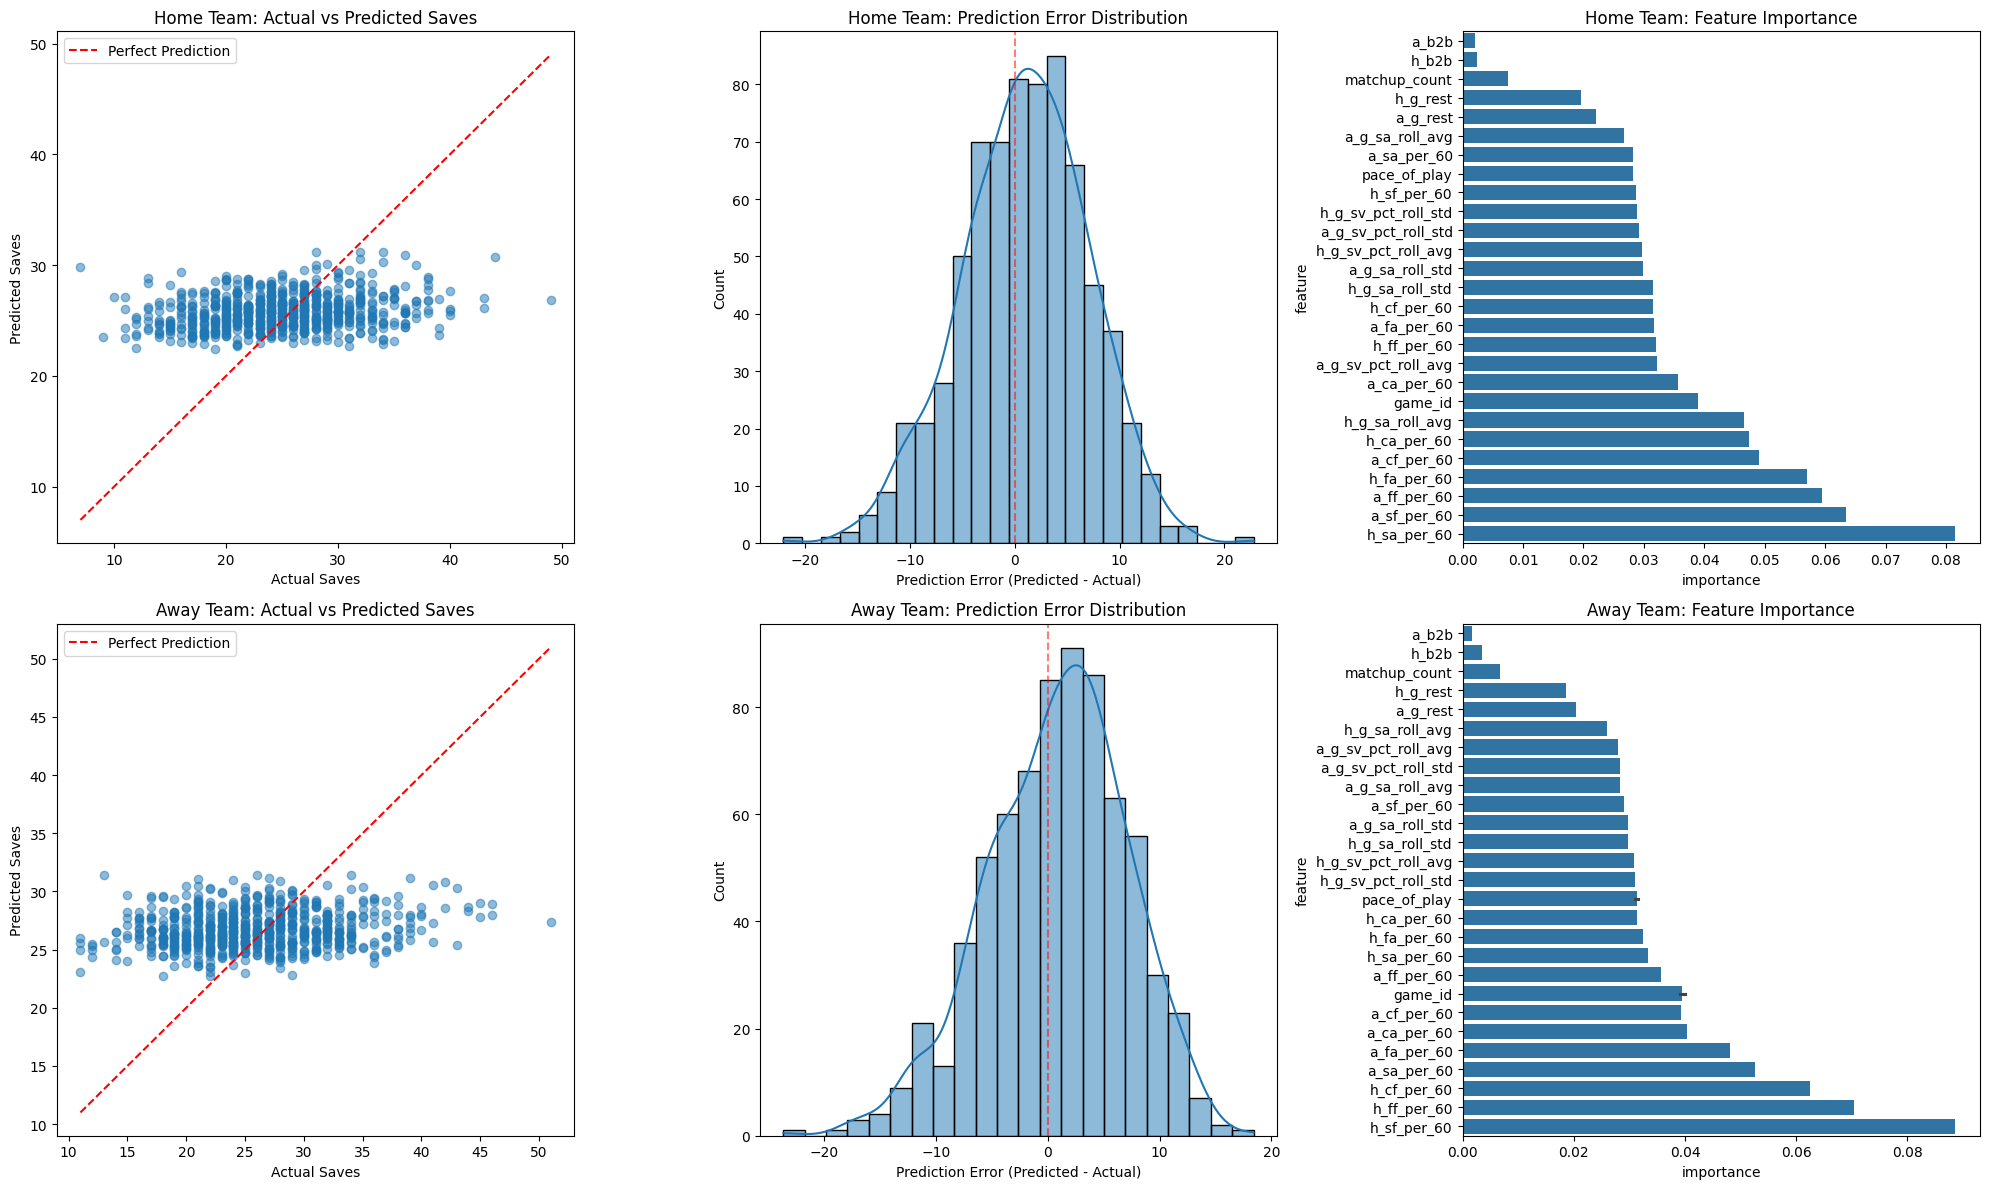


Home Team Error Statistics:
Mean Error: 0.965
Error Std Dev: 6.089
Error Range: [-22.115, 22.796]

Away Team Error Statistics:
Mean Error: 0.820
Error Std Dev: 6.247
Error Range: [-23.649, 18.415]

Predictions within ±1 saves:
Home Team: 13.5%
Away Team: 12.1%

Predictions within ±2 saves:
Home Team: 26.5%
Away Team: 23.6%

Predictions within ±3 saves:
Home Team: 35.8%
Away Team: 34.0%

Predictions within ±5 saves:
Home Team: 58.6%
Away Team: 56.3%


In [244]:
"""Train models to predict both home and away team saves"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team-specific prefixes
base_features = [
    # 'cf_pct', 'ff_pct', 'sf_pct', 'xgf_pct', 
    # 'scf_pct', 'hdcf_pct', 'mdcf_pct', 'ldcf_pct',
    'cf_per_60', 'ca_per_60', 'ff_per_60', 'fa_per_60', 'sf_per_60', 'sa_per_60'
]

# Define goalie-specific features
goalie_features = [
    'g_sa_roll_avg', 'g_sa_roll_std', 'g_sv_pct_roll_avg', 'g_sv_pct_roll_std',
    'g_rest'
]

# Create home and away feature lists
away_features = ['a_' + feat for feat in base_features]
home_features = ['h_' + feat for feat in base_features]  # Use away team features for home model

combined_features = away_features + home_features

away_features = combined_features
home_features = combined_features

# Add goalie-specific features with appropriate prefixes
away_features.extend(['a_' + feat for feat in goalie_features])
home_features.extend(['h_' + feat for feat in goalie_features])

# # Interaction terms and identifiers
away_features.append('pace_of_play')
home_features.append('pace_of_play')
away_features.append('game_id')
home_features.append('game_id')
away_features.append('matchup_count')
home_features.append('matchup_count')
away_features.extend(['a_b2b', 'h_b2b'])
home_features.extend(['a_b2b', 'h_b2b'])

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=120)  # Use last 120 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Prepare home team data
X_home = processed_df[home_features].copy()
y_home = processed_df['h_res_sv']

# Prepare away team data
X_away = processed_df[away_features].copy()
y_away = processed_df['a_res_sv']

# Handle missing values
X_home = X_home.fillna(X_home.mean())
X_away = X_away.fillna(X_away.mean())

# Split into train and test sets
X_home_train = X_home[train_mask]
X_home_test = X_home[test_mask]
y_home_train = y_home[train_mask]
y_home_test = y_home[test_mask]

X_away_train = X_away[train_mask]
X_away_test = X_away[test_mask]
y_away_train = y_away[train_mask]
y_away_test = y_away[test_mask]

print(f"Training data from {processed_df[train_mask]['game_date'].min()} to {processed_df[train_mask]['game_date'].max()}")
print(f"Testing data from {processed_df[test_mask]['game_date'].min()} to {processed_df[test_mask]['game_date'].max()}")

# Scale features
scaler_home = StandardScaler()
scaler_away = StandardScaler()

X_home_train_scaled = scaler_home.fit_transform(X_home_train)
X_home_test_scaled = scaler_home.transform(X_home_test)

X_away_train_scaled = scaler_away.fit_transform(X_away_train)
X_away_test_scaled = scaler_away.transform(X_away_test)

# Train home model
home_model = RandomForestRegressor(
    n_estimators=1500,
    max_depth=10,
    bootstrap=True,
    max_features='log2',
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)
home_model.fit(X_home_train_scaled, y_home_train)

# Train away model
away_model = RandomForestRegressor(
    n_estimators=1500,
    max_depth=10,
    bootstrap=True,
    max_features='log2',
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)
away_model.fit(X_away_train_scaled, y_away_train)

# Make predictions
y_home_pred = home_model.predict(X_home_test_scaled)
y_away_pred = away_model.predict(X_away_test_scaled)

# Calculate evaluation metrics for home model
home_metrics = {
    'r2_score': r2_score(y_home_test, y_home_pred),
    'mae': mean_absolute_error(y_home_test, y_home_pred),
    'rmse': np.sqrt(mean_squared_error(y_home_test, y_home_pred)),
    'feature_importance': dict(zip(home_features, home_model.feature_importances_))
}

# Calculate evaluation metrics for away model
away_metrics = {
    'r2_score': r2_score(y_away_test, y_away_pred),
    'mae': mean_absolute_error(y_away_test, y_away_pred),
    'rmse': np.sqrt(mean_squared_error(y_away_test, y_away_pred)),
    'feature_importance': dict(zip(away_features, away_model.feature_importances_))
}

# Print metrics
print("\nHome Team Model Metrics:")
print(f"R² Score: {home_metrics['r2_score']:.4f}")
print(f"MAE: {home_metrics['mae']:.4f}")
print(f"RMSE: {home_metrics['rmse']:.4f}")

print("\nAway Team Model Metrics:")
print(f"R² Score: {away_metrics['r2_score']:.4f}")
print(f"MAE: {away_metrics['mae']:.4f}")
print(f"RMSE: {away_metrics['rmse']:.4f}")

# Create visualization subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

# 1. Home team actual vs predicted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_home_test, y_home_pred, alpha=0.5)
ax1.plot([y_home_test.min(), y_home_test.max()], [y_home_test.min(), y_home_test.max()], 'r--', label='Perfect Prediction')
ax1.set_title('Home Team: Actual vs Predicted Saves')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.legend()

# 2. Away team actual vs predicted
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_away_test, y_away_pred, alpha=0.5)
ax2.plot([y_away_test.min(), y_away_test.max()], [y_away_test.min(), y_away_test.max()], 'r--', label='Perfect Prediction')
ax2.set_title('Away Team: Actual vs Predicted Saves')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.legend()

# 3. Home team error distribution
home_errors = y_home_pred - y_home_test
ax3 = fig.add_subplot(gs[0, 1])
sns.histplot(home_errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Home Team: Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# 4. Away team error distribution
away_errors = y_away_pred - y_away_test
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(away_errors, kde=True, ax=ax4)
ax4.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax4.set_title('Away Team: Prediction Error Distribution')
ax4.set_xlabel('Prediction Error (Predicted - Actual)')
ax4.set_ylabel('Count')

# 5. Home team feature importance
home_importance = pd.DataFrame({
    'feature': home_features,
    'importance': home_model.feature_importances_
}).sort_values('importance', ascending=True)

ax5 = fig.add_subplot(gs[0, 2])
sns.barplot(data=home_importance, x='importance', y='feature', ax=ax5)
ax5.set_title('Home Team: Feature Importance')

# 6. Away team feature importance
away_importance = pd.DataFrame({
    'feature': away_features,
    'importance': away_model.feature_importances_
}).sort_values('importance', ascending=True)

ax6 = fig.add_subplot(gs[1, 2])
sns.barplot(data=away_importance, x='importance', y='feature', ax=ax6)
ax6.set_title('Away Team: Feature Importance')

plt.tight_layout()
plt.show()

# Print additional error statistics
print("\nHome Team Error Statistics:")
print(f"Mean Error: {home_errors.mean():.3f}")
print(f"Error Std Dev: {home_errors.std():.3f}")
print(f"Error Range: [{home_errors.min():.3f}, {home_errors.max():.3f}]")

print("\nAway Team Error Statistics:")
print(f"Mean Error: {away_errors.mean():.3f}")
print(f"Error Std Dev: {away_errors.std():.3f}")
print(f"Error Range: [{away_errors.min():.3f}, {away_errors.max():.3f}]")

# Calculate percentage of predictions within different margins
for margin in [1, 2, 3, 5]:
    home_within = np.mean(np.abs(home_errors) <= margin) * 100
    away_within = np.mean(np.abs(away_errors) <= margin) * 100
    print(f"\nPredictions within ±{margin} saves:")
    print(f"Home Team: {home_within:.1f}%")
    print(f"Away Team: {away_within:.1f}%")

Preparing data...
Starting RFE analysis...

Starting RFE Analysis for Home Goalie...


/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 64 features.
Fitting estimator with 62 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 63 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 64 features.
Fitting estimator with 59 features.
Fitting estimator with 62 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 61 features.
Fitting estimator with 63 features.
Fitting estimator with 56 features.
Fitting estimator with 62 features.
Fitting estimator with 55 features.
Fitting estimator with 60 features.
Fitting estimator with 63 features.
Fitting estimator with 54 fe

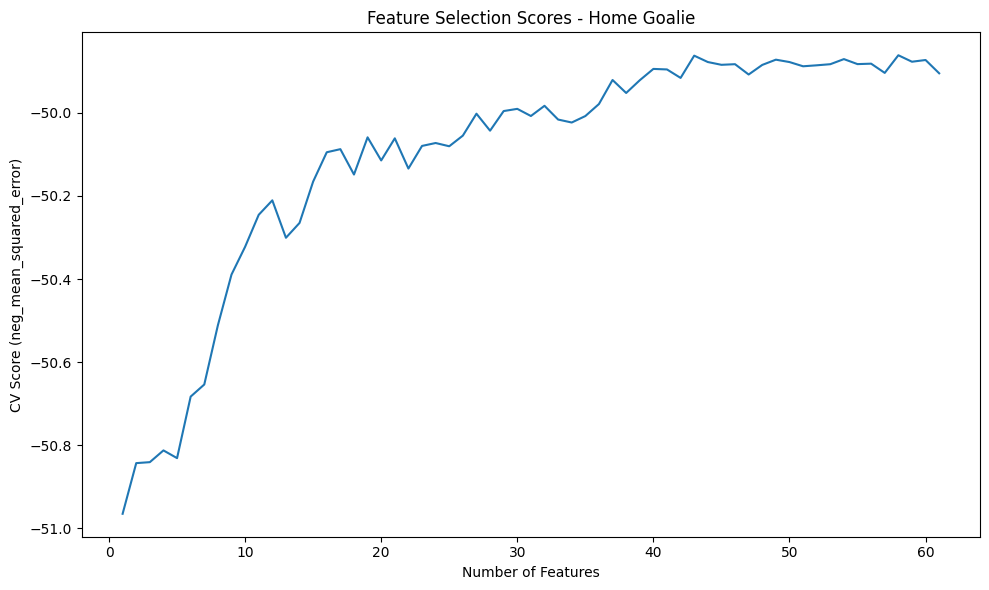


Model Performance with Selected Features (Home Goalie):
R² Score: -0.0792
Mean Absolute Error: 5.5448
Root Mean Squared Error: 6.9261


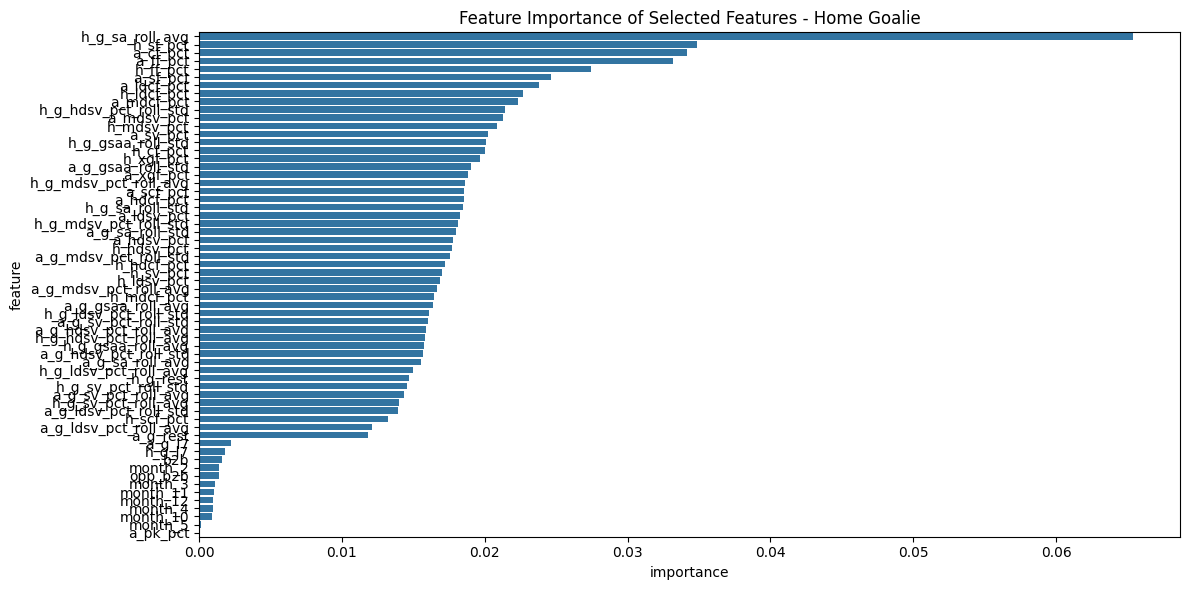

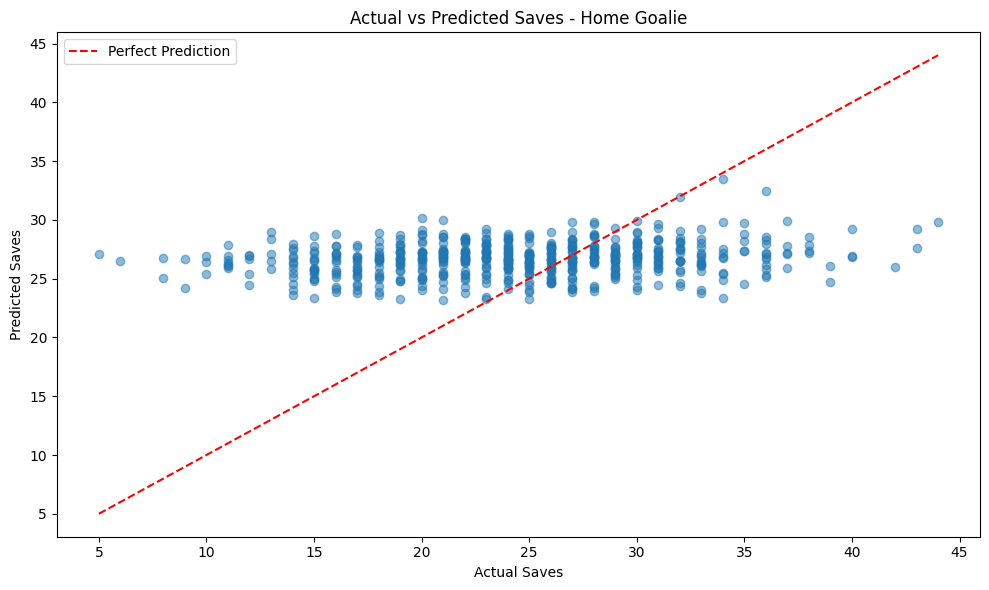


Error Statistics (Home Goalie):
Mean Error: 2.338
Error Std Dev: 6.525
Error Range: [-16.044, 22.122]
Predictions within ±1 saves: 10.54%
Predictions within ±2 saves: 23.93%
Predictions within ±3 saves: 33.75%
Predictions within ±5 saves: 52.86%

Starting RFE Analysis for Away Goalie...


/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 64 features.
Fitting estimator with 62 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.
Fitting estimator with 63 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 62 features.
Fitting estimator with 63 features.
Fitting estimator with 64 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 61 features.
Fitting estimator with 56 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 55 features.
Fitting estimator with 60 features.
Fitting estimator with 54 features.
Fitting estimator with 63 fe

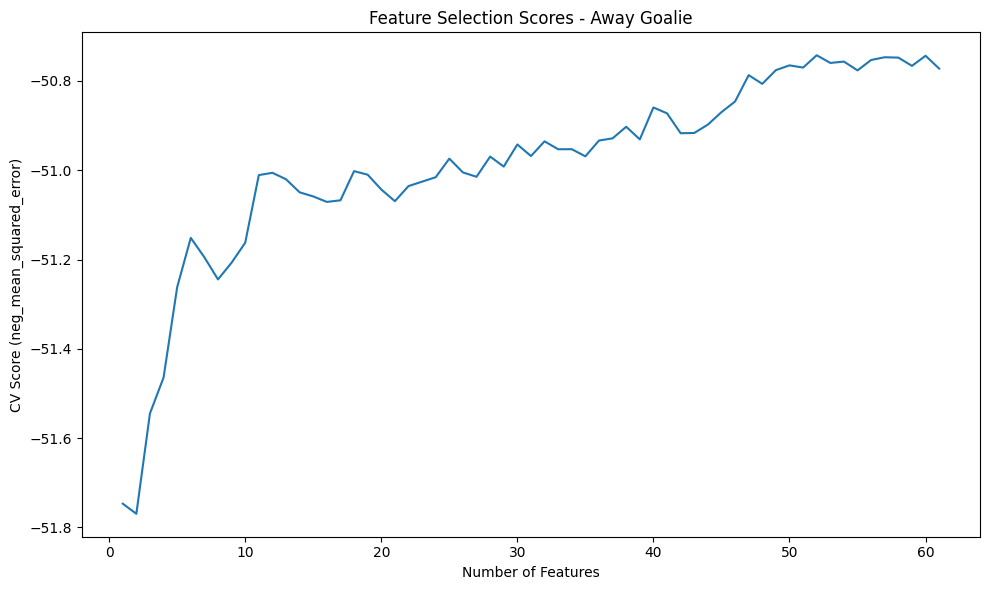


Model Performance with Selected Features (Away Goalie):
R² Score: -0.0878
Mean Absolute Error: 5.5481
Root Mean Squared Error: 6.8970


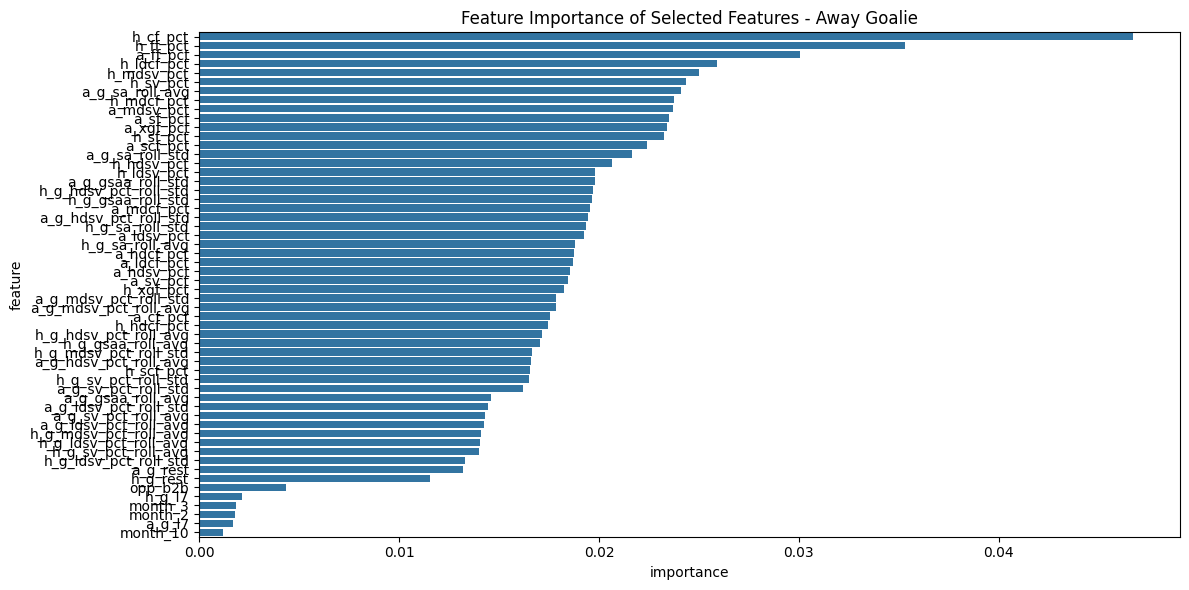

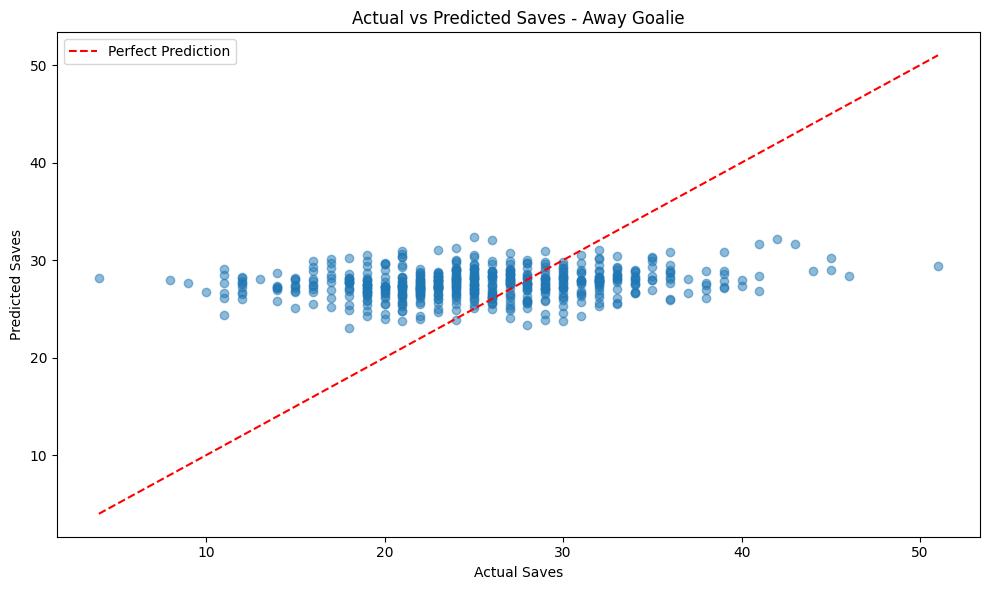


Error Statistics (Away Goalie):
Mean Error: 2.351
Error Std Dev: 6.490
Error Range: [-21.550, 24.201]
Predictions within ±1 saves: 10.54%
Predictions within ±2 saves: 20.54%
Predictions within ±3 saves: 30.18%
Predictions within ±5 saves: 53.57%

Feature Selection Comparison:

Features selected for both models:
- a_cf_pct
- a_ff_pct
- a_g_gsaa_roll_avg
- a_g_gsaa_roll_std
- a_g_hdsv_pct_roll_avg
- a_g_hdsv_pct_roll_std
- a_g_l7
- a_g_ldsv_pct_roll_avg
- a_g_ldsv_pct_roll_std
- a_g_mdsv_pct_roll_avg
- a_g_mdsv_pct_roll_std
- a_g_rest
- a_g_sa_roll_avg
- a_g_sa_roll_std
- a_g_sv_pct_roll_avg
- a_g_sv_pct_roll_std
- a_hdcf_pct
- a_hdsv_pct
- a_ldcf_pct
- a_ldsv_pct
- a_mdcf_pct
- a_mdsv_pct
- a_scf_pct
- a_sf_pct
- a_sv_pct
- a_xgf_pct
- h_cf_pct
- h_ff_pct
- h_g_gsaa_roll_avg
- h_g_gsaa_roll_std
- h_g_hdsv_pct_roll_avg
- h_g_hdsv_pct_roll_std
- h_g_l7
- h_g_ldsv_pct_roll_avg
- h_g_ldsv_pct_roll_std
- h_g_mdsv_pct_roll_avg
- h_g_mdsv_pct_roll_std
- h_g_rest
- h_g_sa_roll_avg
- h_g_sa_rol

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Define initial features (excluding target variables and non-predictive columns)
features = [
    # Team performance metrics
    'h_cf_pct', 'h_ff_pct', 'h_sf_pct', 'h_xgf_pct', 
    'h_scf_pct', 'h_hdcf_pct', 'h_mdcf_pct', 'h_ldcf_pct',
    'a_cf_pct', 'a_ff_pct', 'a_sf_pct', 'a_xgf_pct',
    'a_scf_pct', 'a_hdcf_pct', 'a_mdcf_pct', 'a_ldcf_pct',
    
    # Save percentages and shooting metrics
    'h_sv_pct', 'h_hdsv_pct', 'h_mdsv_pct', 'h_ldsv_pct',
    'a_sv_pct', 'a_hdsv_pct', 'a_mdsv_pct', 'a_ldsv_pct',
    
    # Special teams
    'h_pp_pct', 'h_pk_pct', 'a_pp_pct', 'a_pk_pct',
    
    # Goalie rolling metrics
    'h_g_sa_roll_avg', 'h_g_sa_roll_std',
    'h_g_sv_pct_roll_avg', 'h_g_sv_pct_roll_std',
    'h_g_gsaa_roll_avg', 'h_g_gsaa_roll_std',
    'h_g_hdsv_pct_roll_avg', 'h_g_hdsv_pct_roll_std',
    'h_g_mdsv_pct_roll_avg', 'h_g_mdsv_pct_roll_std',
    'h_g_ldsv_pct_roll_avg', 'h_g_ldsv_pct_roll_std',
    
    'a_g_sa_roll_avg', 'a_g_sa_roll_std',
    'a_g_sv_pct_roll_avg', 'a_g_sv_pct_roll_std',
    'a_g_gsaa_roll_avg', 'a_g_gsaa_roll_std',
    'a_g_hdsv_pct_roll_avg', 'a_g_hdsv_pct_roll_std',
    'a_g_mdsv_pct_roll_avg', 'a_g_mdsv_pct_roll_std',
    'a_g_ldsv_pct_roll_avg', 'a_g_ldsv_pct_roll_std',
    
    # Game context
    'b2b', 'opp_b2b', 'h_g_rest', 'a_g_rest',
    'h_g_l7', 'a_g_l7', 'month'
]

# Function to perform RFE analysis
def perform_rfe_analysis(X, y, train_mask, test_mask, target_name):
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize the base estimator for RFECV
    base_estimator = RandomForestRegressor(
        n_estimators=500,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize RFECV
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=tscv,
        scoring='neg_mean_squared_error',
        min_features_to_select=5,
        n_jobs=-1,
        verbose=2
    )
    
    print(f"\nStarting RFE Analysis for {target_name}...")
    rfecv.fit(X_train_scaled, y_train)
    
    # Get selected features
    selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]
    
    print(f"\nOptimal number of features for {target_name}:", rfecv.n_features_)
    print("\nSelected features:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i}. {feature}")
    
    # Plot number of features vs CV score
    plt.figure(figsize=(10, 6))
    mean_scores = rfecv.cv_results_['mean_test_score']
    plt.plot(range(1, len(mean_scores) + 1), mean_scores)
    plt.xlabel('Number of Features')
    plt.ylabel('CV Score (neg_mean_squared_error)')
    plt.title(f'Feature Selection Scores - {target_name}')
    plt.tight_layout()
    plt.show()
    
    # Train final model with selected features
    X_train_selected = X_train_scaled[:, rfecv.support_]
    X_test_selected = X_test_scaled[:, rfecv.support_]
    
    final_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_selected, y_train)
    
    # Make predictions
    y_pred = final_model.predict(X_test_selected)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    
    print(f"\nModel Performance with Selected Features ({target_name}):")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f}")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")
    
    # Feature importance of selected features
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Feature Importance of Selected Features - {target_name}')
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title(f'Actual vs Predicted Saves - {target_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate error statistics
    errors = y_pred - y_test
    print(f"\nError Statistics ({target_name}):")
    print(f"Mean Error: {errors.mean():.3f}")
    print(f"Error Std Dev: {errors.std():.3f}")
    print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")
    
    # Calculate percentage of predictions within different error margins
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return rfecv, final_model, selected_features, metrics

# Prepare the data
print("Preparing data...")
X = processed_df[features].copy()
y_home = processed_df['h_res_sv']  # Predicting home goalie saves
y_away = processed_df['a_res_sv']  # Predicting away goalie saves

# Handle missing values
X = X.fillna(X.mean())

# Convert boolean columns to int
X['b2b'] = X['b2b'].astype(int)
X['opp_b2b'] = X['opp_b2b'].astype(int)

# Convert month to categorical
X['month'] = X['month'].astype('category')
X = pd.get_dummies(X, columns=['month'], drop_first=True)

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

print("Starting RFE analysis...")
# Perform RFE analysis for home and away goalies
home_results = perform_rfe_analysis(X, y_home, train_mask, test_mask, "Home Goalie")
away_results = perform_rfe_analysis(X, y_away, train_mask, test_mask, "Away Goalie")

# Compare selected features between home and away models
home_selected = set(home_results[2])
away_selected = set(away_results[2])

print("\nFeature Selection Comparison:")
print("\nFeatures selected for both models:")
for feature in sorted(home_selected.intersection(away_selected)):
    print(f"- {feature}")

print("\nFeatures unique to home model:")
for feature in sorted(home_selected - away_selected):
    print(f"- {feature}")

print("\nFeatures unique to away model:")
for feature in sorted(away_selected - home_selected):
    print(f"- {feature}")

Total number of features: 102
First 10 features: ['game_id', 'home', 'gp', 'toi', 'cf', 'ca', 'cf_pct', 'ff', 'fa', 'ff_pct']
Last 10 features: ['g_mdsv_pct_roll_avg', 'g_mdsv_pct_roll_std', 'g_ld_sa_roll_avg', 'g_ld_sa_roll_std', 'g_ldsv_pct_roll_avg', 'g_ldsv_pct_roll_std', 'g_rest', 'g_l7', 'month', 'matchup_count']
Data types in the feature set:
float64    94
int64       6
object      1
int32       1
Name: count, dtype: int64
Numeric features: 100
Categorical features: 1
Filled NaN in cf with median: 173.0
Filled NaN in ca with median: 173.0
Filled NaN in ff with median: 129.0
Filled NaN in fa with median: 129.0
Filled NaN in sf with median: 92.0
Filled NaN in sa with median: 92.0
Filled NaN in gf with median: 9.0
Filled NaN in ga with median: 9.0
Filled NaN in scf with median: 83.0
Filled NaN in sca with median: 84.0
Filled NaN in scsf with median: 49.0
Filled NaN in scsa with median: 49.0
Filled NaN in scgf with median: 7.0
Filled NaN in scga with median: 7.0
Filled NaN in hdcf w

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_79925/1166806471.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_value, inplace=True)
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_79925/1166806471.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

Reduced to 51 features for RFECV
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 featu

/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  26.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.3min
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  26.2s
[CV] END max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1500; total time= 6.1min
[CV] END max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1500; total time= 6.0min
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  52.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  52.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  52.2s
[CV] END max_depth=15, max_featu

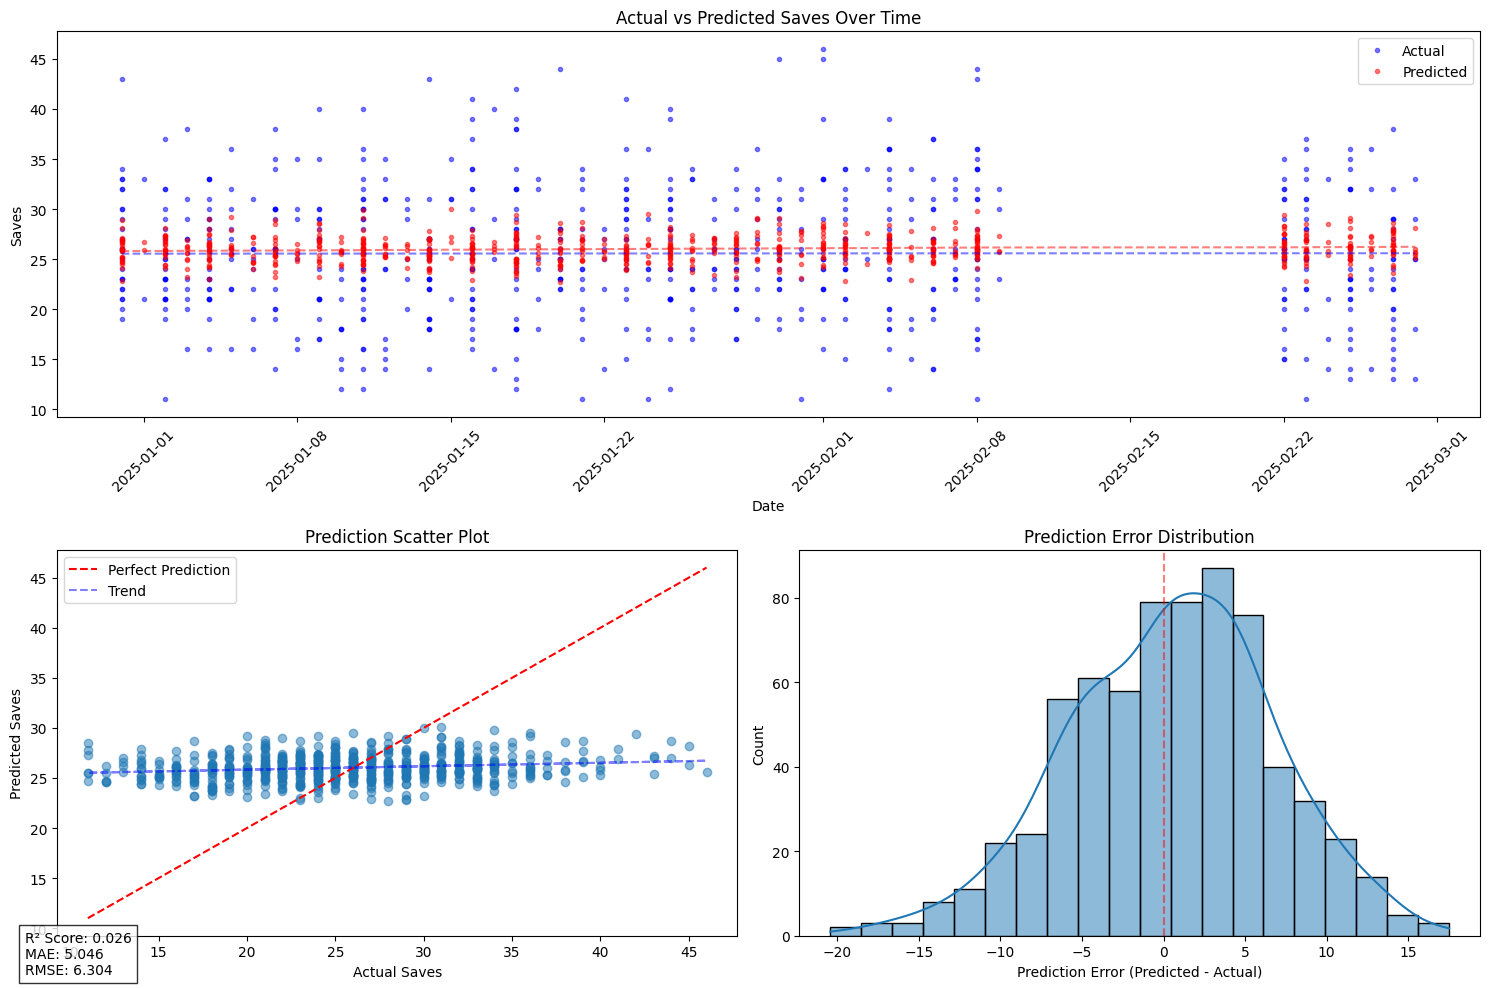


Error Statistics:
Mean Error: 0.446
Error Std Dev: 6.293
Error Range: [-20.427, 17.501]


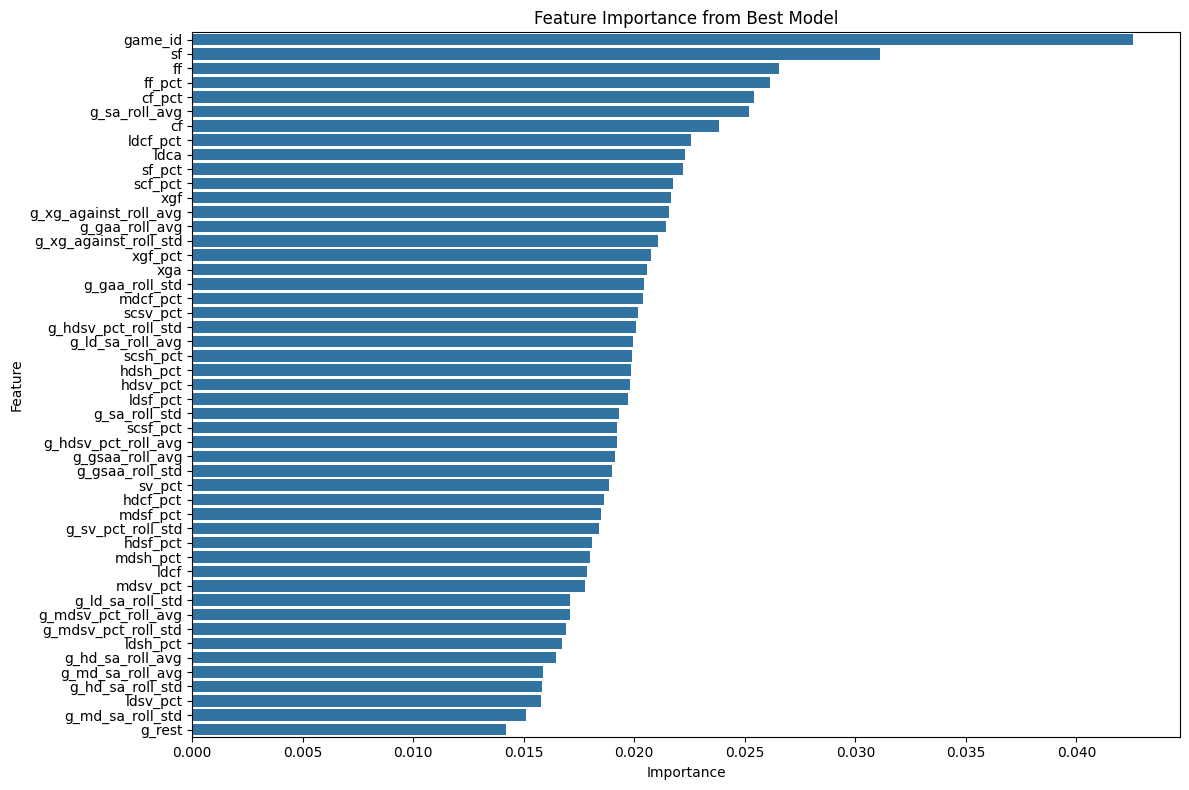

AttributeError: 'RFECV' object has no attribute 'grid_scores_'

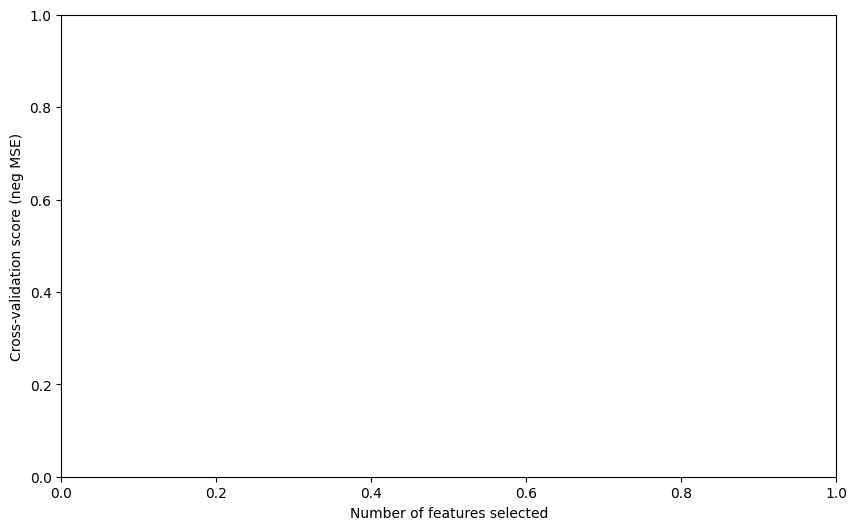

In [20]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Get all columns except those with 'res_' in their names and exclude non-feature columns
exclude_patterns = ['res_', 'game_date', 'goalie', 'team', 'opponent', 'goalie_id']
all_columns = processed_df.columns.tolist()
features = [col for col in all_columns if not any(pattern in col for pattern in exclude_patterns)]

print(f"Total number of features: {len(features)}")
print("First 10 features:", features[:10])
print("Last 10 features:", features[-10:])

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=60)  # Use last 60 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Get the raw feature data
X = processed_df[features].copy()

# Identify data types of each column
print("Data types in the feature set:")
print(X.dtypes.value_counts())

# Handle different feature types correctly
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create a safer imputation for numeric features
for col in numeric_features:
    if X[col].isna().any():
        median_value = X[col].median()
        X[col].fillna(median_value, inplace=True)
        print(f"Filled NaN in {col} with median: {median_value}")

# Handle categorical features
if categorical_features:
    # Fill missing values in categorical columns before one-hot encoding
    for col in categorical_features:
        if X[col].isna().any():
            mode_value = X[col].mode()[0]
            X[col].fillna(mode_value, inplace=True)
            print(f"Filled NaN in {col} with mode: {mode_value}")
    
    # Convert categorical variables to one-hot encoding
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Now X should contain only numerical features (original numeric + one-hot encoded categoricals)
print(f"Features after preprocessing: {X.shape[1]}")

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training data from {processed_df[train_mask]['game_date'].min()} to {processed_df[train_mask]['game_date'].max()}")
print(f"Testing data from {processed_df[test_mask]['game_date'].min()} to {processed_df[test_mask]['game_date'].max()}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using Recursive Feature Elimination with Cross-Validation
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# First, let's run a quick RandomForest to get initial feature importances
base_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
base_rf.fit(X_train_scaled, y_train)

# Get feature importances and keep the top 50% most important features to speed up RFECV
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': base_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Select top 50% of features for further consideration
top_features_count = max(len(X_train.columns) // 2, 10)  # At least 10 features
top_features = feature_importances.head(top_features_count)['feature'].values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale the reduced feature set
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

print(f"Reduced to {len(top_features)} features for RFECV")

# Run RFECV to find optimal features
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=5,
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train_top_scaled, y_train)

# Get the selected features
selected_features = top_features[rfecv.support_]
print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected features:", selected_features.tolist())

# Use only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scale the selected features
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create the grid search object with 5-fold cross-validation
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    scoring='neg_mean_squared_error',
    verbose=2
)

# Fit the grid search to the training data
print("Starting grid search. This may take some time...")
grid_search.fit(X_train_selected_scaled, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Use the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test_selected_scaled)

# Calculate evaluation metrics with the best model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(selected_features, best_rf_model.feature_importances_))
}

print("\nBest Model Performance on Test Set:")
print(f"R² Score: {metrics['r2_score']:.3f}")
print(f"MAE: {metrics['mae']:.3f}")
print(f"RMSE: {metrics['rmse']:.3f}")

# Create a figure with multiple subplots
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

# Visualize feature importance from the best model
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot the RFECV results
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (neg MSE)")
plt.plot(range(rfecv.min_features_to_select, len(rfecv.grid_scores_) + rfecv.min_features_to_select), rfecv.grid_scores_)
plt.title("Recursive Feature Elimination with Cross-Validation")
plt.tight_layout()
plt.show()

# Display the grid search results as a DataFrame for better analysis
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(10)
display(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])


Total number of parameter combinations: 16
Total number of fits: 48

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=0, reg_lambda=1.0, subsample

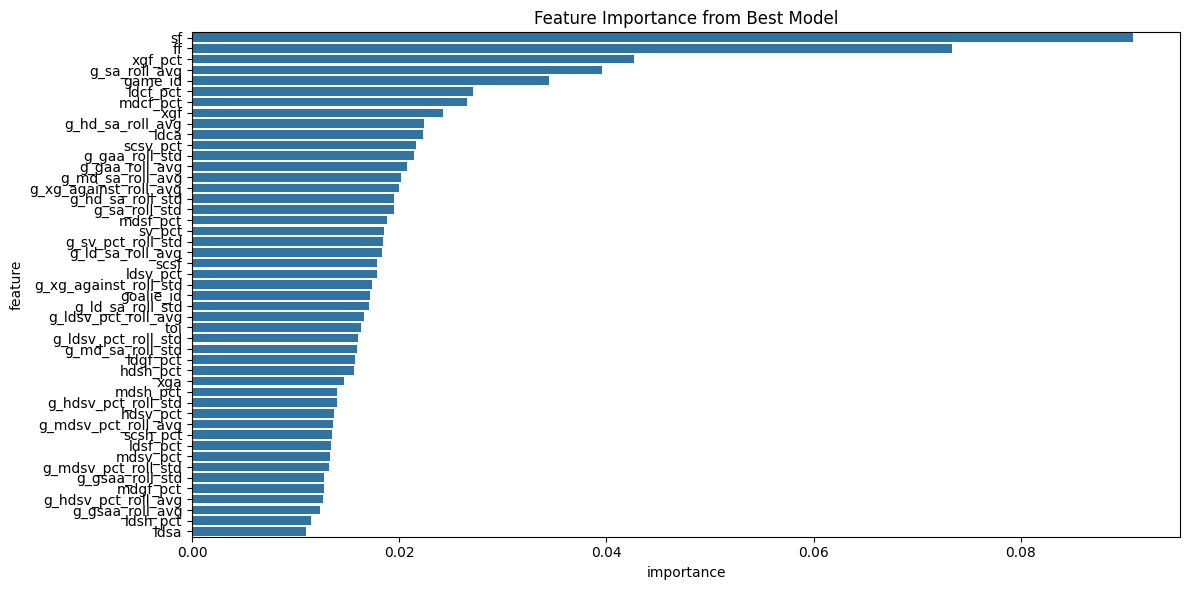

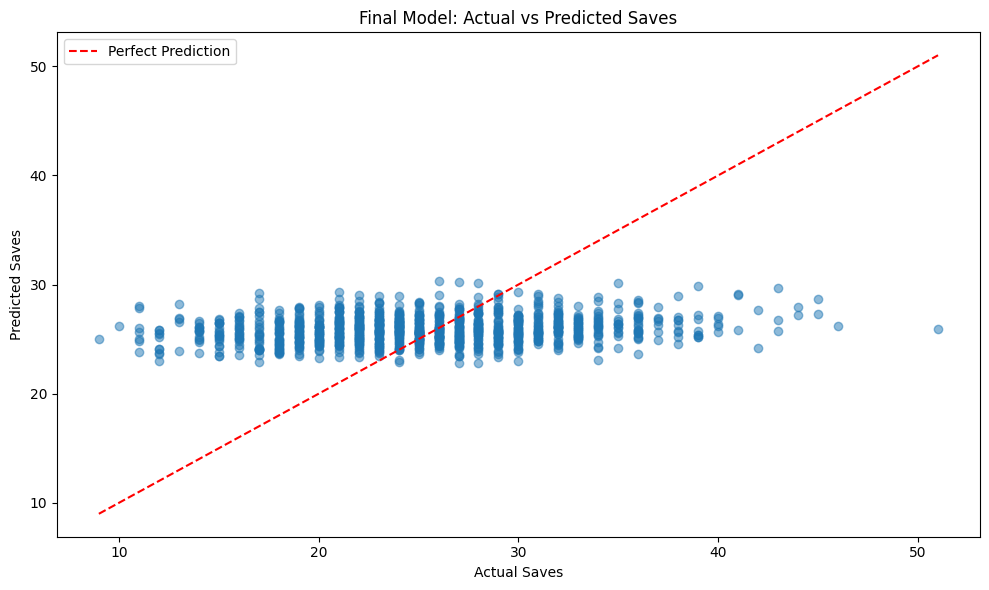

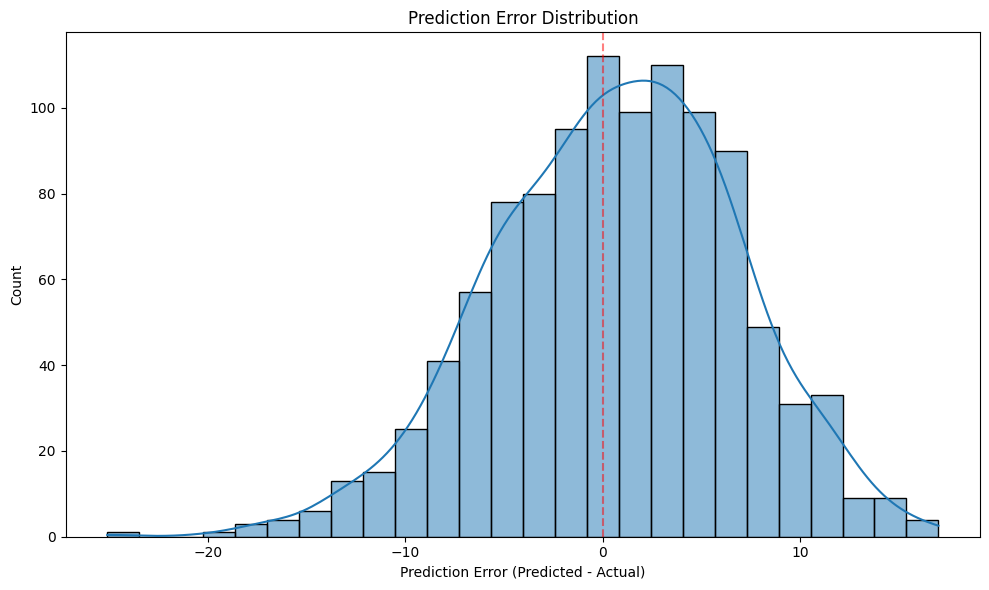


Total execution time: 5.59 seconds


In [ ]:
# Import XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'sf', 'g_sa_roll_avg', 'g_md_sa_roll_avg', 'game_id', 'g_md_sa_roll_std', 
    'g_ld_sa_roll_std', 'g_gsaa_roll_std', 'g_hd_sa_roll_std', 'g_ld_sa_roll_avg', 
    'g_hdsv_pct_roll_avg', 'toi', 'g_mdsv_pct_roll_avg', 'g_mdsv_pct_roll_std', 
    'g_xg_against_roll_avg', 'g_sa_roll_std', 'g_xg_against_roll_std', 'g_gaa_roll_avg', 
    'g_hdsv_pct_roll_std', 'g_hd_sa_roll_avg', 'g_ldsv_pct_roll_avg', 'ldsv_pct', 
    'g_gaa_roll_std', 'hdsh_pct', 'xgf', 'g_gsaa_roll_avg', 'ldsh_pct', 'mdsh_pct', 
    'g_sv_pct_roll_std', 'g_ldsv_pct_roll_std', 'mdsv_pct', 'hdsv_pct', 'ldcf_pct', 
    'ldca', 'ldgf_pct', 'mdsf_pct', 'scsv_pct', 'mdcf_pct', 'scsh_pct', 'xga', 
    'ldsa', 'mdgf_pct', 'xgf_pct', 'ldsf_pct', 'sv_pct', 'ff', 'scsf',
    'goalie_id'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more focused parameter grid to reduce computation time
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for faster execution

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 3}")  # 3 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=20
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 15776 samples
Test set size: 1805 samples
Training voting ensemble model...

===== Model Evaluation Metrics =====

----- Regression Performance -----
R² Score: 0.0145
Explained Variance: 0.0249
Mean Absolute Error: 5.0293 saves
Median Absolute Error: 4.3045 saves
Root Mean Squared Error: 6.2897 saves
Maximum Error: 24.5679 saves

----- Error Distribution -----
Mean Error: 0.6480 saves
Error Standard Deviation: 6.2562
Error Skewness: -0.2611
Error Kurtosis: 0.1970
Normality Test p-value: 0.0000

----- Error Percentiles -----
Min Error: -24.5679 saves
25th Percentile: -3.4494 saves
Median Error: 0.9580 saves
75th Percentile: 4.8637 saves
Max Error: 22.8066 saves
Interquartile Range: 8.3131 saves

----- Prediction Accuracy -----
Predictions within ±1 saves: 12.52%
Predictions within ±2 saves: 24.16%
Predictions within ±3 saves: 35.79%
Predictions within ±5 saves: 57.62%


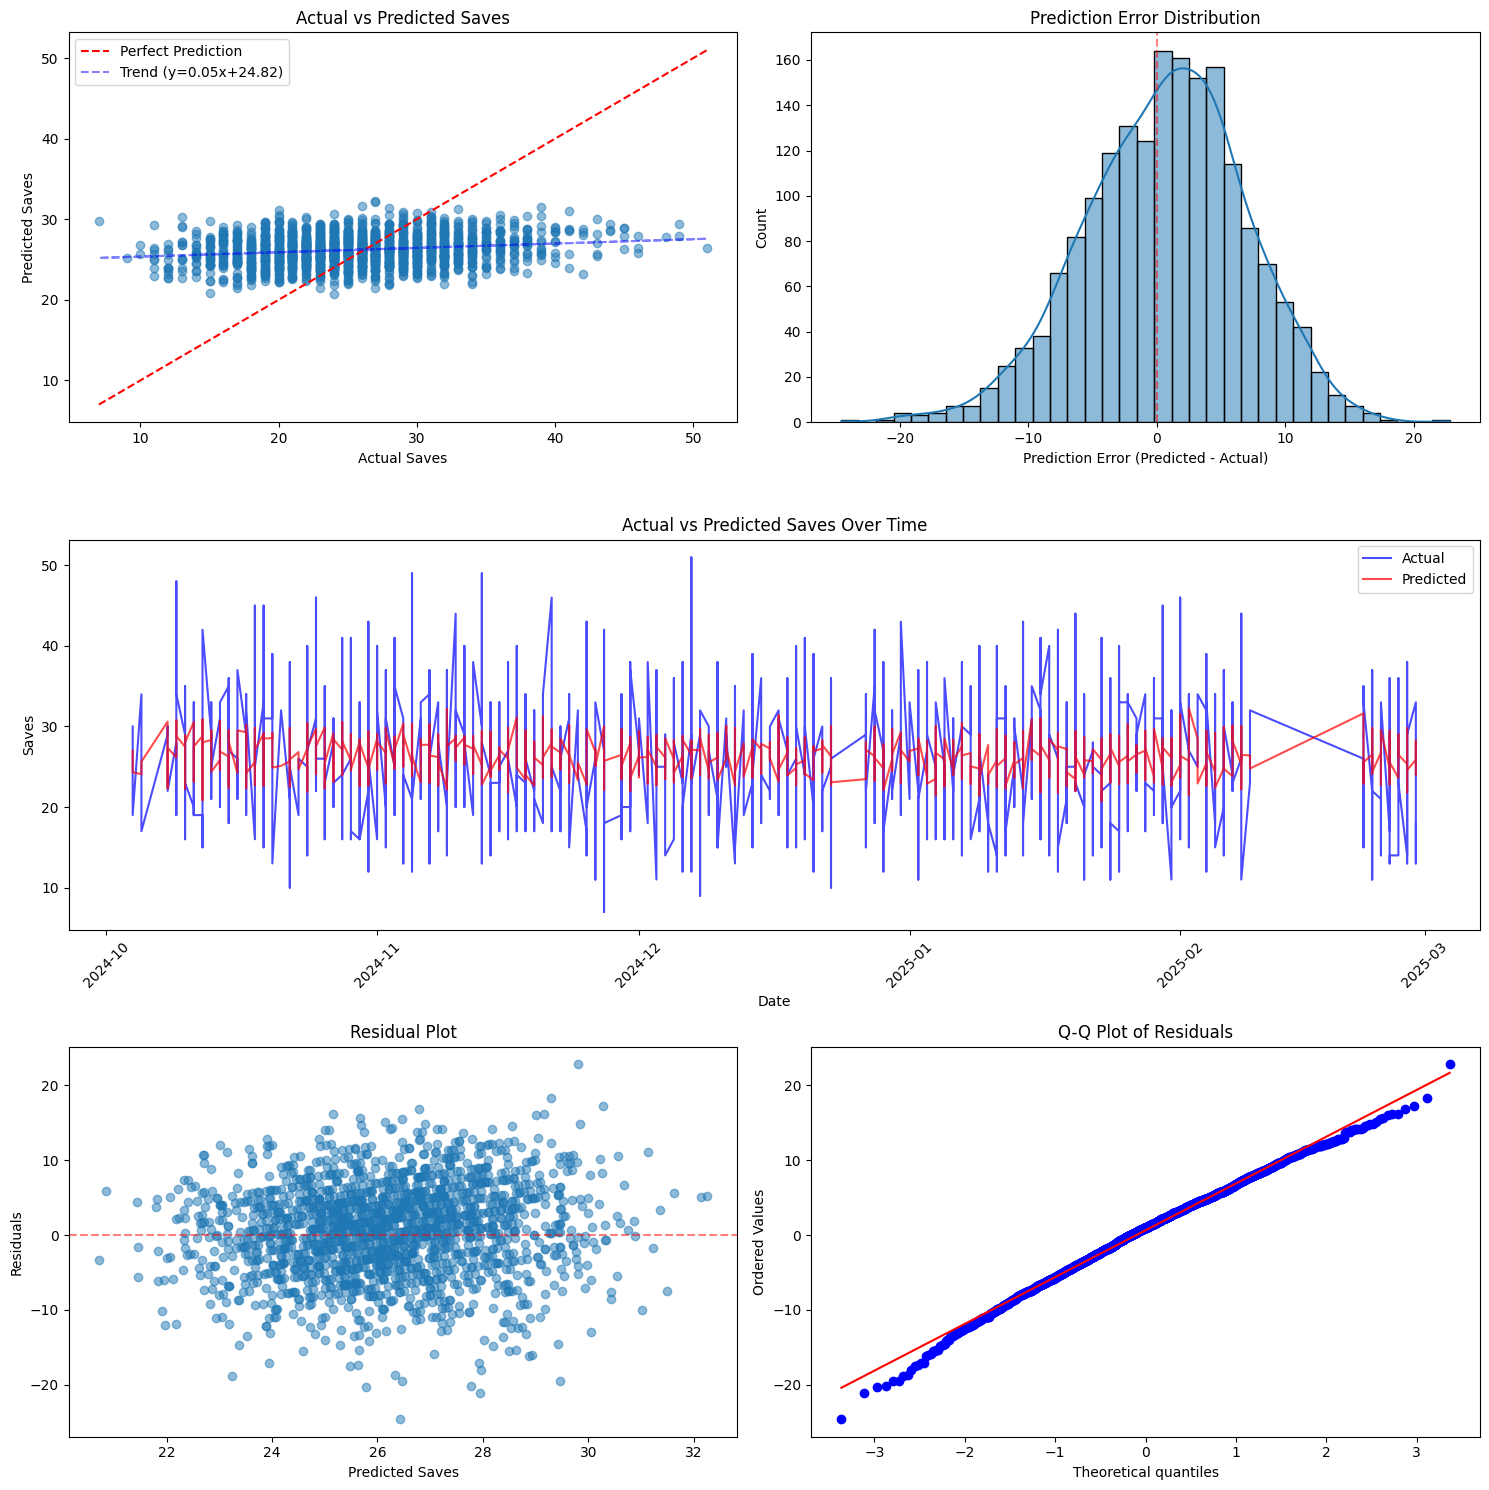

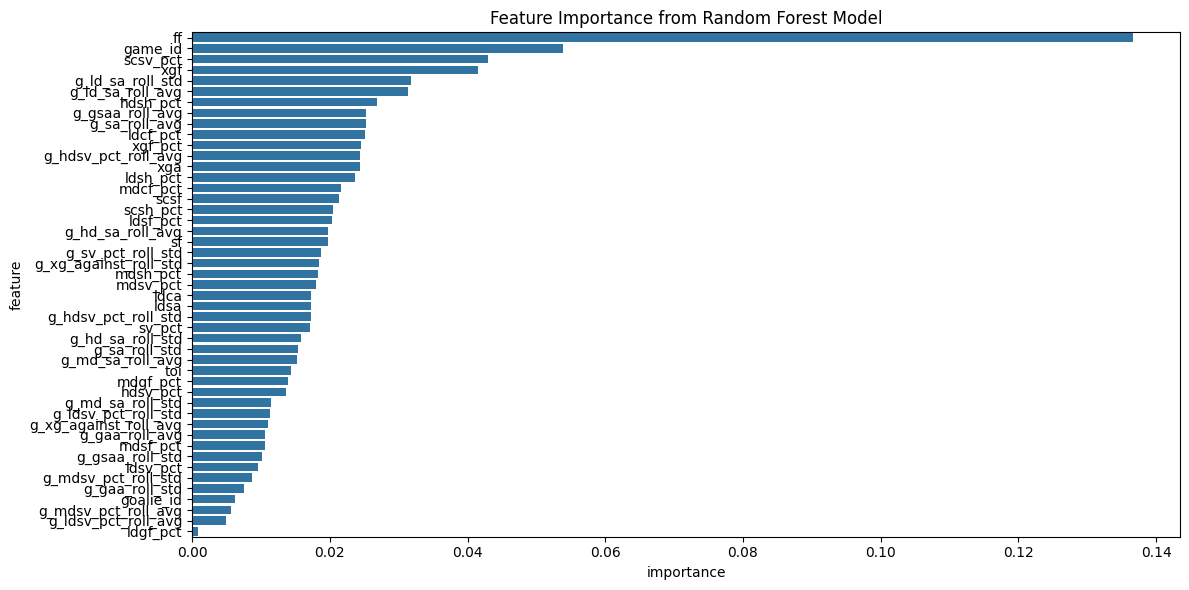


Total execution time: 44.98 seconds


In [19]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = ['sf', 'g_sa_roll_avg', 'g_md_sa_roll_avg', 'game_id', 'g_md_sa_roll_std', 
    'g_ld_sa_roll_std', 'g_gsaa_roll_std', 'g_hd_sa_roll_std', 'g_ld_sa_roll_avg', 
    'g_hdsv_pct_roll_avg', 'toi', 'g_mdsv_pct_roll_avg', 'g_mdsv_pct_roll_std', 
    'g_xg_against_roll_avg', 'g_sa_roll_std', 'g_xg_against_roll_std', 'g_gaa_roll_avg', 
    'g_hdsv_pct_roll_std', 'g_hd_sa_roll_avg', 'g_ldsv_pct_roll_avg', 'ldsv_pct', 
    'g_gaa_roll_std', 'hdsh_pct', 'xgf', 'g_gsaa_roll_avg', 'ldsh_pct', 'mdsh_pct', 
    'g_sv_pct_roll_std', 'g_ldsv_pct_roll_std', 'mdsv_pct', 'hdsv_pct', 'ldcf_pct', 
    'ldca', 'ldgf_pct', 'mdsf_pct', 'scsv_pct', 'mdcf_pct', 'scsh_pct', 'xga', 
    'ldsa', 'mdgf_pct', 'xgf_pct', 'ldsf_pct', 'sv_pct', 'ff', 'scsf',
    'goalie_id'
]   

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=180)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, bootstrap=True, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.01, random_state=42)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))
]

# Create voting ensemble (simpler than stacking)
voting_model = VotingRegressor(
    estimators=base_models,
    weights=[0.3, 0.3, 0.2, 0.1, 0.1]  # Giving more weight to tree-based models
)

# Create pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_model)
])

# Train the model
print("Training voting ensemble model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate comprehensive metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'explained_variance': explained_variance_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'median_ae': median_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'max_error': max_error(y_test, y_pred),
    'mean_error': np.mean(y_pred - y_test),
    'std_error': np.std(y_pred - y_test)
}

# Calculate additional statistical metrics
errors = y_pred - y_test
metrics.update({
    'error_skewness': stats.skew(errors),
    'error_kurtosis': stats.kurtosis(errors),
    'error_normality_pvalue': stats.normaltest(errors)[1],
    'error_min': np.min(errors),
    'error_max': np.max(errors),
    'error_q1': np.percentile(errors, 25),
    'error_median': np.median(errors),
    'error_q3': np.percentile(errors, 75),
    'error_iqr': np.percentile(errors, 75) - np.percentile(errors, 25)
})

# Calculate percentage of predictions within different error margins
for margin in [1, 2, 3, 5]:
    metrics[f'within_{margin}_saves'] = np.mean(np.abs(errors) <= margin) * 100

# Print metrics in a formatted table
print("\n===== Model Evaluation Metrics =====")
print("\n----- Regression Performance -----")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Explained Variance: {metrics['explained_variance']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
print(f"Median Absolute Error: {metrics['median_ae']:.4f} saves")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
print(f"Maximum Error: {metrics['max_error']:.4f} saves")

print("\n----- Error Distribution -----")
print(f"Mean Error: {metrics['mean_error']:.4f} saves")
print(f"Error Standard Deviation: {metrics['std_error']:.4f}")
print(f"Error Skewness: {metrics['error_skewness']:.4f}")
print(f"Error Kurtosis: {metrics['error_kurtosis']:.4f}")
print(f"Normality Test p-value: {metrics['error_normality_pvalue']:.4f}")

print("\n----- Error Percentiles -----")
print(f"Min Error: {metrics['error_min']:.4f} saves")
print(f"25th Percentile: {metrics['error_q1']:.4f} saves")
print(f"Median Error: {metrics['error_median']:.4f} saves")
print(f"75th Percentile: {metrics['error_q3']:.4f} saves")
print(f"Max Error: {metrics['error_max']:.4f} saves")
print(f"Interquartile Range: {metrics['error_iqr']:.4f} saves")

print("\n----- Prediction Accuracy -----")
for margin in [1, 2, 3, 5]:
    print(f"Predictions within ±{margin} saves: {metrics[f'within_{margin}_saves']:.2f}%")

# Create a figure with multiple subplots for visualization
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2)

# 1. Actual vs Predicted scatter plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test, p(y_test), "b--", alpha=0.5, label=f'Trend (y={z[0]:.2f}x+{z[1]:.2f})')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.set_title('Actual vs Predicted Saves')
ax1.legend()

# 2. Error distribution histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(errors, kde=True, ax=ax2)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Prediction Error Distribution')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Count')

# 3. Time series of actual vs predicted
ax3 = fig.add_subplot(gs[1, :])
# Get dates for test set
test_dates = processed_df.loc[test_mask, 'game_date']
ax3.plot(test_dates, y_test, 'b-', label='Actual', alpha=0.7)
ax3.plot(test_dates, y_pred, 'r-', label='Predicted', alpha=0.7)
ax3.set_title('Actual vs Predicted Saves Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Saves')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Residual plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_pred, errors, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Saves')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')

# 5. QQ plot for normality check
ax5 = fig.add_subplot(gs[2, 1])
stats.probplot(errors, plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest model
rf_model = pipeline.named_steps['model'].estimators_[0][1]
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 15776 samples
Test set size: 1805 samples
Using 47 features after engineering
Selected features:
  1. sf
  2. g_md_sa_roll_avg
  3. game_id
  4. g_hd_sa_roll_std
  5. g_hdsv_pct_roll_std
  6. g_hd_sa_roll_avg
  7. hdsh_pct
  8. xgf
  9. ldsh_pct
  10. mdsh_pct
  11. ldcf_pct
  12. mdsf_pct
  13. mdcf_pct
  14. ff
  15. goalie_id
Training neural network for 200 epochs...
Progress: [==] 2/200 epochs - 1.0s elapsed, ~96.9s remaining
Train loss: 101.5258, Val loss: 65.2546
Progress: [==] 4/200 epochs - 1.2s elapsed, ~57.0s remaining
Train loss: 73.4395, Val loss: 51.1584
Progress: [==] 6/200 epochs - 1.3s elapsed, ~43.2s remaining
Train loss: 67.0996, Val loss: 48.8839
Progress: [==] 8/200 epochs - 1.5s elapsed, ~36.2s remaining
Train loss: 63.0899, Val loss: 43.5136
Progress: [==] 10/200 epochs - 1.7s elapsed, ~31.9s remaining
Train loss: 61.4787, Val loss: 42.1118
Progress: [==] 12/200 epochs - 1.9s elapsed, ~29.0s remaining
Train loss: 60.1091, Val loss: 42.9518
Progr

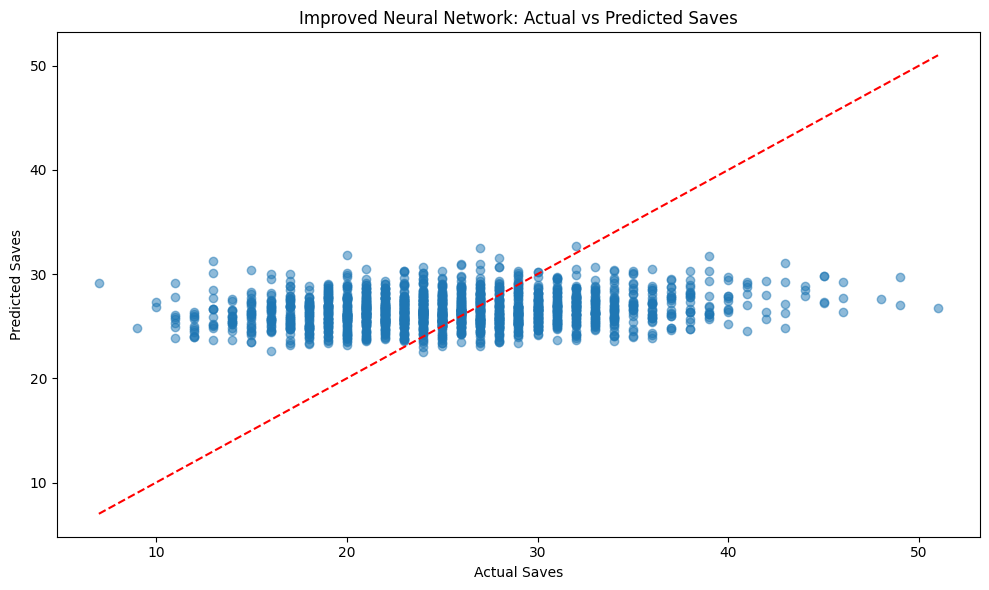

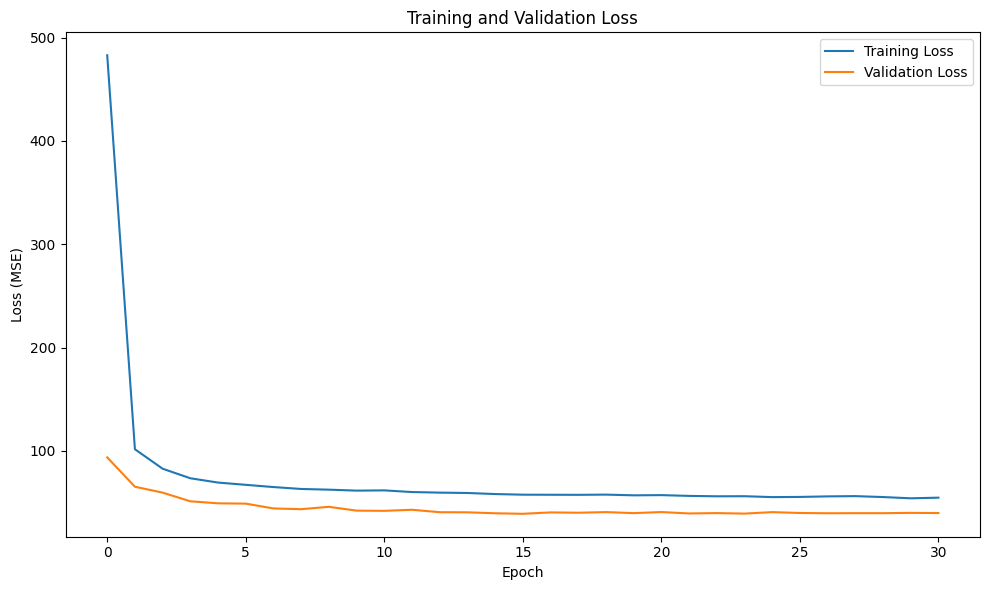


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0102
Mean Absolute Error: 5.0583 saves
Root Mean Squared Error: 6.3034 saves
Predictions within ±1 saves: 12.19%
Predictions within ±2 saves: 22.77%
Predictions within ±3 saves: 35.12%
Predictions within ±5 saves: 57.29%


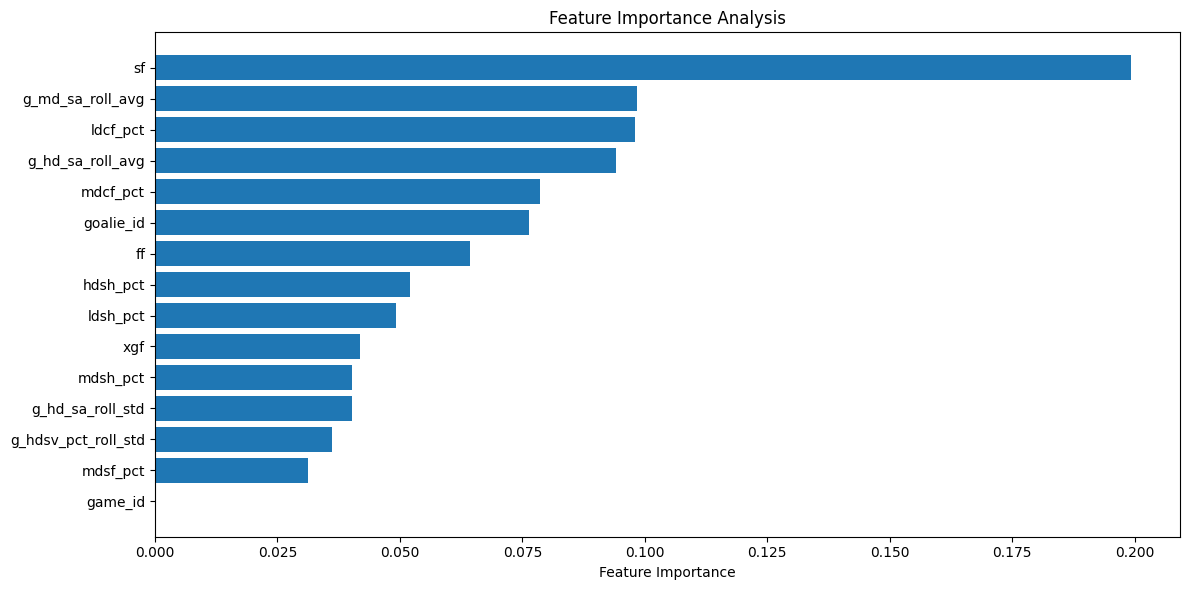

In [20]:


# Define a dataset class for our goalie data
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more complex neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More complex architecture with additional layers
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),  # Larger first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout for regularization
            nn.Linear(32, 16),  # Add another hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train the model with improved parameters
def train_nn_model_ultrafast(X_train, y_train, X_test, y_test, 
                             batch_size=64, epochs=200, learning_rate=0.001,
                             weight_decay=1e-5, patience=10):
    """
    Ultra-fast training function with improved parameters
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Quick validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to run an improved neural network evaluation
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with feature engineering
    """
    # Define base features using the new feature set
    base_features = ['sf', 'g_sa_roll_avg', 'g_md_sa_roll_avg', 'game_id', 'g_md_sa_roll_std', 
    'g_ld_sa_roll_std', 'g_gsaa_roll_std', 'g_hd_sa_roll_std', 'g_ld_sa_roll_avg', 
    'g_hdsv_pct_roll_avg', 'toi', 'g_mdsv_pct_roll_avg', 'g_mdsv_pct_roll_std', 
    'g_xg_against_roll_avg', 'g_sa_roll_std', 'g_xg_against_roll_std', 'g_gaa_roll_avg', 
    'g_hdsv_pct_roll_std', 'g_hd_sa_roll_avg', 'g_ldsv_pct_roll_avg', 'ldsv_pct', 
    'g_gaa_roll_std', 'hdsh_pct', 'xgf', 'g_gsaa_roll_avg', 'ldsh_pct', 'mdsh_pct', 
    'g_sv_pct_roll_std', 'g_ldsv_pct_roll_std', 'mdsv_pct', 'hdsv_pct', 'ldcf_pct', 
    'ldca', 'ldgf_pct', 'mdsf_pct', 'scsv_pct', 'mdcf_pct', 'scsh_pct', 'xga', 
    'ldsa', 'mdgf_pct', 'xgf_pct', 'ldsf_pct', 'sv_pct', 'ff', 'scsf',
    'goalie_id']

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Feature engineering - create meaningful interactions
    # X['sv_danger_interaction'] = X['g_hdsv_pct_roll_avg'] * X['g_mdsv_pct_roll_avg'] * X['g_ldsv_pct_roll_avg']
    # X['shots_danger_ratio'] = X['g_hd_sa_roll_avg'] / (X['g_md_sa_roll_avg'] + X['g_ld_sa_roll_avg']).replace(0, 0.001)
    # X['pp_pk_time_ratio'] = X['pp_toi'] / X['pk_toi'].replace(0, 0.001)
    
    # # Create polynomial features for key metrics
    # X['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    # X['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    # # Create ratio features
    # X['hd_md_sv_ratio'] = X['g_hdsv_pct_roll_avg'] / X['g_mdsv_pct_roll_avg'].replace(0, 0.001)
    
    # Handle missing values
    X = X.fillna(X.mean())

    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=180)

    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Feature selection using mutual information
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    
    # Select top features (adjust k as needed)
    k = min(15, X_train.shape[1])
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get names of selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train the neural network with improved settings
    model, y_pred, metrics = train_nn_model_ultrafast(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=64,
        epochs=200,
        learning_rate=0.001,
        weight_decay=1e-5,
        patience=15
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        feature_importance = model.feature_importances_
    else:
        # For neural networks, use a simple sensitivity analysis
        feature_importance = []
        model.eval()
        with torch.no_grad():
            baseline = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().flatten()
            for i in range(X_test_scaled.shape[1]):
                # Perturb each feature and measure the effect
                X_perturbed = X_test_scaled.copy()
                X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
                perturbed = model(torch.tensor(X_perturbed, dtype=torch.float32)).numpy().flatten()
                importance = np.mean(np.abs(perturbed - baseline))
                feature_importance.append(importance)
        
        # Normalize importances
        feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    return model, scaler, metrics, selected_features

# Run the improved neural network model
improved_nn_model, improved_nn_scaler, improved_nn_metrics, selected_features = run_improved_goalie_nn()

Using device: cpu
No GPU available, using CPU
Training set size: 17322 samples
Test set size: 259 samples
Using 47 features after engineering
Selected features:
  1. g_hdsv_pct_roll_avg
  2. g_xg_against_roll_avg
  3. ldsf_pct
  4. xga
  5. g_hdsv_pct_roll_std
  6. g_hd_sa_roll_avg
  7. goalie_id
  8. mdsh_pct
  9. mdcf_pct
  10. xgf
  11. xgf_pct
  12. g_md_sa_roll_avg
  13. mdsf_pct
  14. ldca
  15. g_sa_roll_avg
  16. scsf
  17. ldcf_pct
  18. game_id
  19. ff
  20. sf

===== Training Single Neural Network =====
Training neural network for 300 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:167: FutureWarning

====] 5/300 epochs - 1.0s elapsed, ~58.4s remaining
Train loss: 17.9855, Val loss: 17.7077, LR: 0.000505
Progress: [=====] 10/300 epochs - 1.9s elapsed, ~55.0s remaining
Train loss: 11.5622, Val loss: 13.8487, LR: 0.001000
Progress: [=====] 15/300 epochs - 2.8s elapsed, ~52.8s remaining
Train loss: 5.3428, Val loss: 4.3542, LR: 0.000855
Progress: [=====] 20/300 epochs - 3.7s elapsed, ~51.3s remaining
Train loss: 5.3176, Val loss: 4.3998, LR: 0.000505
Progress: [=====] 25/300 epochs - 4.5s elapsed, ~50.0s remaining
Train loss: 5.2424, Val loss: 4.4685, LR: 0.000155
Progress: [=====] 30/300 epochs - 5.5s elapsed, ~49.4s remaining
Train loss: 5.2551, Val loss: 4.5289, LR: 0.001000
Progress: [==
Early stopping triggered after 33 epochs

Training completed in 6.02 seconds


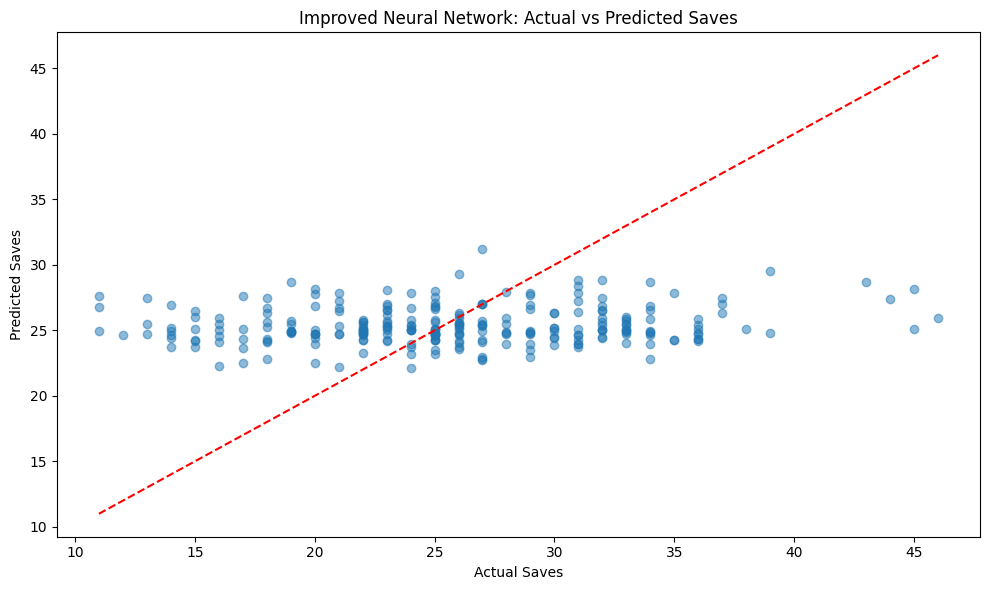

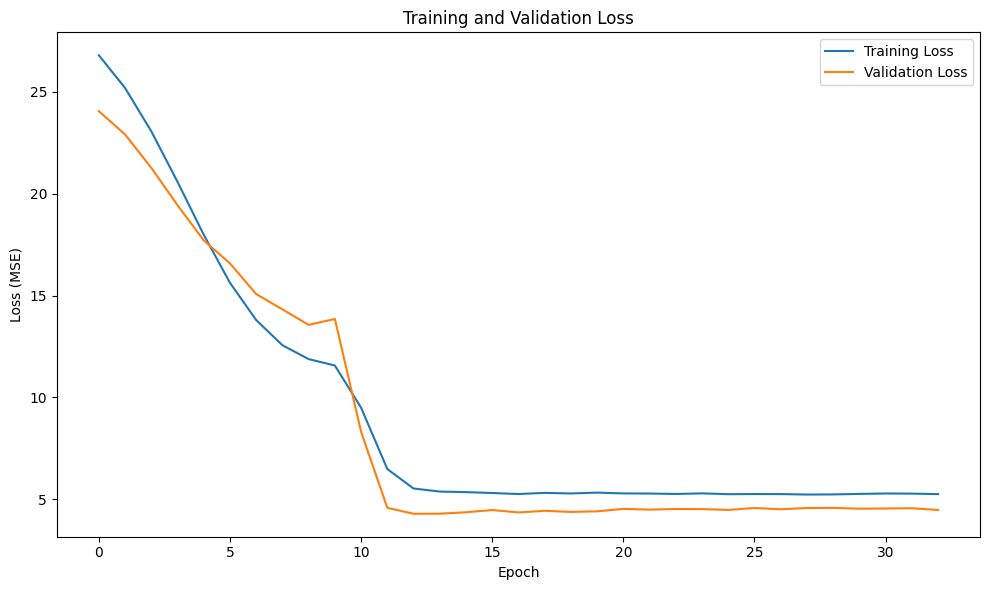


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0135
Mean Absolute Error: 5.3506 saves
Root Mean Squared Error: 6.7049 saves
Predictions within ±1 saves: 12.74%
Predictions within ±2 saves: 23.55%
Predictions within ±3 saves: 34.75%
Predictions within ±5 saves: 52.51%


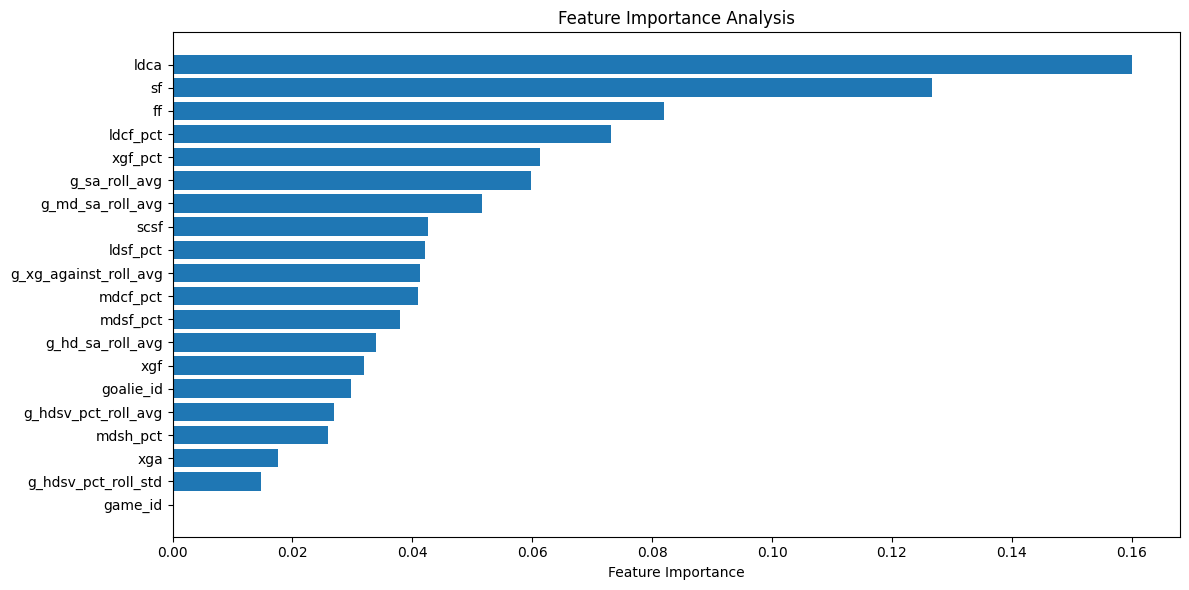


===== Creating Ensemble Model =====

Training model 1/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:167: FutureWarning

====] 5/200 epochs - 1.0s elapsed, ~37.4s remaining
Train loss: 17.4805, Val loss: 7.6190, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.9s elapsed, ~35.7s remaining
Train loss: 11.7403, Val loss: 5.6841, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.8s elapsed, ~34.1s remaining
Train loss: 5.3604, Val loss: 4.2859, LR: 0.000855
Progress: [=====] 20/200 epochs - 3.6s elapsed, ~32.8s remaining
Train loss: 5.2888, Val loss: 4.2064, LR: 0.000505
Progress: [=====] 25/200 epochs - 4.6s elapsed, ~32.1s remaining
Train loss: 5.2621, Val loss: 4.2402, LR: 0.000155
Progress: [=====] 30/200 epochs - 5.5s elapsed, ~31.0s remaining
Train loss: 5.2685, Val loss: 4.1745, LR: 0.001000
Progress: [=====] 35/200 epochs - 6.4s elapsed, ~30.0s remaining
Train loss: 5.2330, Val loss: 4.3150, LR: 0.000962
Progress: [=====] 40/200 epochs - 7.3s elapsed, ~29.3s remaining
Train loss: 5.1782, Val loss: 4.2771, LR: 0.000855
Progress: [====
Early stopping triggered after 45 epochs

Training completed in 8.3

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:167: FutureWarning

====] 5/200 epochs - 1.0s elapsed, ~37.9s remaining
Train loss: 18.6262, Val loss: 13.6311, LR: 0.000505
Progress: [=====] 10/200 epochs - 2.0s elapsed, ~37.2s remaining
Train loss: 12.0816, Val loss: 9.6719, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.9s elapsed, ~35.6s remaining
Train loss: 5.3505, Val loss: 4.4257, LR: 0.000855
Progress: [=====] 20/200 epochs - 3.8s elapsed, ~33.8s remaining
Train loss: 5.2421, Val loss: 4.3898, LR: 0.000505
Progress: [=====] 25/200 epochs - 4.6s elapsed, ~32.3s remaining
Train loss: 5.2224, Val loss: 4.3887, LR: 0.000155
Progress: [=====] 30/200 epochs - 5.5s elapsed, ~31.1s remaining
Train loss: 5.2299, Val loss: 4.4582, LR: 0.001000
Progress: [=====] 35/200 epochs - 6.3s elapsed, ~29.9s remaining
Train loss: 5.2320, Val loss: 4.4038, LR: 0.000962
Progress: [=====] 40/200 epochs - 7.2s elapsed, ~28.9s remaining
Train loss: 5.1969, Val loss: 4.3901, LR: 0.000855
Progress: [=====] 45/200 epochs - 8.1s elapsed, ~27.9s remaining
Train loss: 5.210

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:167: FutureWarning

====] 5/200 epochs - 0.9s elapsed, ~34.9s remaining
Train loss: 16.6469, Val loss: 11.8082, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.8s elapsed, ~33.5s remaining
Train loss: 10.1026, Val loss: 7.8400, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.6s elapsed, ~32.5s remaining
Train loss: 5.3224, Val loss: 4.8018, LR: 0.000855
Progress: [=====] 20/200 epochs - 3.5s elapsed, ~31.4s remaining
Train loss: 5.2942, Val loss: 4.5299, LR: 0.000505
Progress: [=====] 25/200 epochs - 4.4s elapsed, ~30.5s remaining
Train loss: 5.2386, Val loss: 4.5686, LR: 0.000155
Progress: [=====] 30/200 epochs - 5.2s elapsed, ~29.7s remaining
Train loss: 5.2250, Val loss: 4.5563, LR: 0.001000
Progress: [=
Early stopping triggered after 32 epochs

Training completed in 5.60 seconds

Training model 4/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:167: FutureWarning

====] 5/200 epochs - 0.9s elapsed, ~35.2s remaining
Train loss: 17.3818, Val loss: 10.9836, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.8s elapsed, ~33.6s remaining
Train loss: 10.5889, Val loss: 7.7680, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.6s elapsed, ~32.4s remaining
Train loss: 5.3202, Val loss: 4.3353, LR: 0.000855
Progress: [=====] 20/200 epochs - 3.5s elapsed, ~31.6s remaining
Train loss: 5.2835, Val loss: 4.3083, LR: 0.000505
Progress: [=====] 25/200 epochs - 4.4s elapsed, ~30.6s remaining
Train loss: 5.2480, Val loss: 4.3883, LR: 0.000155
Progress: [===
Early stopping triggered after 29 epochs

Training completed in 5.07 seconds

Training model 5/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_1520/3810223431.py:167: FutureWarning

====] 5/200 epochs - 0.9s elapsed, ~34.0s remaining
Train loss: 16.6809, Val loss: 13.4312, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.7s elapsed, ~32.9s remaining
Train loss: 9.9407, Val loss: 8.0319, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.6s elapsed, ~32.2s remaining
Train loss: 5.2905, Val loss: 4.3892, LR: 0.000855
Progress: [=====] 20/200 epochs - 3.5s elapsed, ~31.3s remaining
Train loss: 5.2278, Val loss: 4.3889, LR: 0.000505
Progress: [=====] 25/200 epochs - 4.3s elapsed, ~30.4s remaining
Train loss: 5.2594, Val loss: 4.3815, LR: 0.000155
Progress: [=====] 30/200 epochs - 5.2s elapsed, ~29.5s remaining
Train loss: 5.2605, Val loss: 4.3973, LR: 0.001000
Progress: [==
Early stopping triggered after 33 epochs

Training completed in 5.73 seconds

===== Ensemble Model Evaluation =====
R² Score: 0.0086
Mean Absolute Error: 5.3811 saves
Root Mean Squared Error: 6.7215 saves
Predictions within ±1 saves: 12.36%
Predictions within ±2 saves: 24.32%
Predictions within ±3 sa

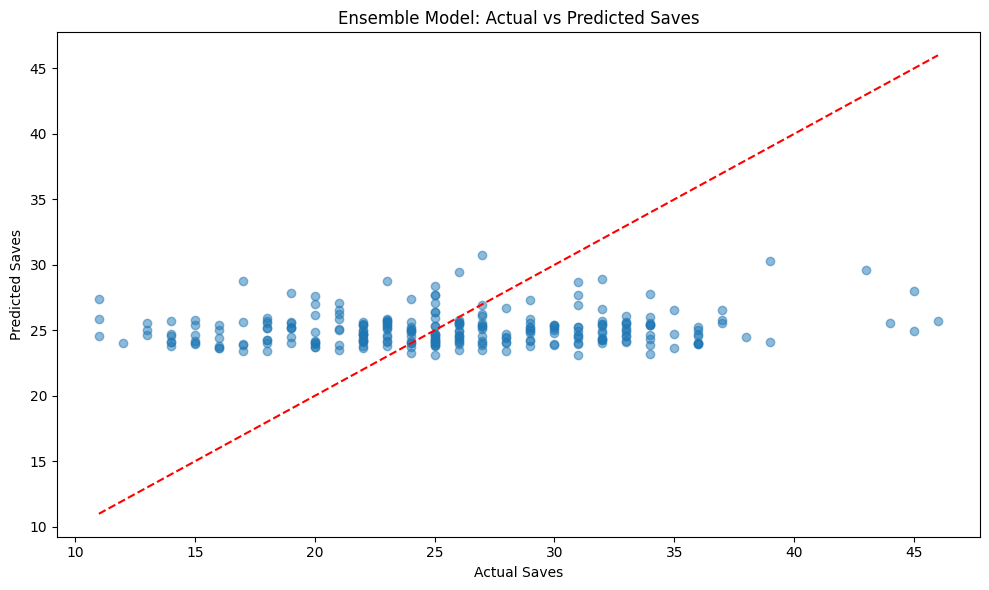


===== Single Model vs Ensemble Comparison =====
Single Model R²: 0.0135 | Ensemble R²: 0.0086
Single Model MAE: 5.3506 | Ensemble MAE: 5.3811
Single Model RMSE: 6.7049 | Ensemble RMSE: 6.7215


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from torch.cuda.amp import autocast, GradScaler

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA benchmarking for performance optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

# Function to monitor GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Define a dataset class for our goalie data with GPU support
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more sophisticated neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More sophisticated architecture with batch normalization and residual connections
        self.bn_input = nn.BatchNorm1d(input_size)
        
        # First block
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second block
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        
        # Third block
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.1)
        
        # Output layer
        self.fc_out = nn.Linear(16, 1)
    
    def forward(self, x):
        # Input normalization
        x = self.bn_input(x)
        
        # First block
        x1 = F.leaky_relu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)
        
        # Second block
        x2 = F.leaky_relu(self.bn2(self.fc2(x1)))
        x2 = self.dropout2(x2)
        
        # Third block
        x3 = F.leaky_relu(self.bn3(self.fc3(x2)))
        x3 = self.dropout3(x3)
        
        # Output
        return self.fc_out(x3)

# Enhanced training function with GPU support and mixed precision
def train_nn_model_enhanced(X_train, y_train, X_test, y_test, 
                           batch_size=128, epochs=300, learning_rate=0.001,
                           weight_decay=1e-4, patience=20):
    """
    Enhanced training function with GPU support and mixed precision training
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1]).to(device)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Use AdamW optimizer for better weight decay handling
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add cosine annealing scheduler for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-5
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Use mixed precision for forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Scale the loss and call backward
            scaler.scale(loss).backward()
            
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Step and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        # Early stopping logic with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print_gpu_memory()  # Monitor GPU memory usage
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Test data is already on GPU from the dataset
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Create an ensemble of neural networks with GPU support
def create_ensemble_model(X_train, y_train, X_test, y_test):
    """
    Create an ensemble of neural networks with GPU support
    """
    # Number of models in ensemble
    n_models = 5
    predictions = np.zeros((X_test.shape[0], n_models))
    
    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models} for ensemble")
        
        # Create a bootstrap sample
        indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_boot = X_train[indices]
        y_boot = y_train.iloc[indices]
        
        # Train model with different random seed
        torch.manual_seed(42 + i)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42 + i)
            
        model, y_pred, _ = train_nn_model_enhanced(
            X_boot, y_boot, X_test, y_test,
            batch_size=128,
            epochs=200,  # Fewer epochs for each model
            learning_rate=0.001,
            weight_decay=1e-4,
            patience=15
        )
        
        # Store predictions
        predictions[:, i] = y_pred
    
    # Ensemble prediction (median for robustness)
    ensemble_pred = np.median(predictions, axis=1)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, ensemble_pred),
        'mae': mean_absolute_error(y_test, ensemble_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred))
    }
    
    print("\n===== Ensemble Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = ensemble_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return ensemble_pred, metrics

# Run an improved version of the neural network model with GPU support
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with GPU support
    """
    # Define base features using the new feature set
    base_features = ['sf', 'g_sa_roll_avg', 'g_md_sa_roll_avg', 'game_id', 'g_md_sa_roll_std', 
    'g_ld_sa_roll_std', 'g_gsaa_roll_std', 'g_hd_sa_roll_std', 'g_ld_sa_roll_avg', 
    'g_hdsv_pct_roll_avg', 'toi', 'g_mdsv_pct_roll_avg', 'g_mdsv_pct_roll_std', 
    'g_xg_against_roll_avg', 'g_sa_roll_std', 'g_xg_against_roll_std', 'g_gaa_roll_avg', 
    'g_hdsv_pct_roll_std', 'g_hd_sa_roll_avg', 'g_ldsv_pct_roll_avg', 'ldsv_pct', 
    'g_gaa_roll_std', 'hdsh_pct', 'xgf', 'g_gsaa_roll_avg', 'ldsh_pct', 'mdsh_pct', 
    'g_sv_pct_roll_std', 'g_ldsv_pct_roll_std', 'mdsv_pct', 'hdsv_pct', 'ldcf_pct', 
    'ldca', 'ldgf_pct', 'mdsf_pct', 'scsv_pct', 'mdcf_pct', 'scsh_pct', 'xga', 
    'ldsa', 'mdgf_pct', 'xgf_pct', 'ldsf_pct', 'sv_pct', 'ff', 'scsf',
    'goalie_id'
        ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Advanced feature engineering
    # 1. Create composite metrics
    # X['danger_weighted_sv'] = (X['g_hdsv_pct_roll_avg'] * 3 + 
    #                           X['g_mdsv_pct_roll_avg'] * 2 + 
    #                           X['g_ldsv_pct_roll_avg']) / 6
    
    # X['danger_weighted_shots'] = (X['g_hd_sa_roll_avg'] * 3 + 
    #                              X['g_md_sa_roll_avg'] * 2 + 
    #                              X['g_ld_sa_roll_avg']) / 6
    
    # # 2. Create ratios and interactions
    # X['hd_ld_ratio'] = X['g_hd_sa_roll_avg'] / X['g_ld_sa_roll_avg'].replace(0, 0.001)
    # X['sv_consistency'] = X['g_sv_pct_roll_avg'] / (X['g_sv_pct_roll_std'] + 0.001)
    # X['xg_efficiency'] = X['g_gsaa_roll_avg'] / (X['g_xg_against_roll_avg'] + 0.001)
    
    # # 3. Create polynomial features for key metrics
    # X['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    # X['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    # # 4. Create team performance interactions
    # X['team_offense_defense'] = X['sf_pct'] * X['scf_pct']
    # X['special_teams_effect'] = X['pp_toi'] * X['pp_pdo'] - X['pk_toi'] * X['pk_pdo']
    
    # # 5. Create goalie workload metrics
    # X['workload_intensity'] = X['g_sa_roll_avg'] * X['g_xg_against_roll_avg']
    # X['danger_mix'] = X['g_hd_sa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Handle missing values with more sophisticated approach
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            # For percentage columns, fill with median
            if 'pct' in col or col.endswith('_pct'):
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())
    
    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)
    
    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Improved feature selection using a combination of methods
    # Use both mutual information and F-test for feature selection
    k = min(20, X_train.shape[1])  # Increase from 15 to 20 features
    
    # Mutual information selector
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_scores = mi_selector.fit(X_train, y_train).scores_
    
    # F-test selector
    f_selector = SelectKBest(f_regression, k=k)
    f_scores = f_selector.fit(X_train, y_train).scores_
    
    # Combine scores (normalize first)
    mi_scores = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-10)
    f_scores = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-10)
    combined_scores = mi_scores + f_scores
    
    # Select top features based on combined score
    top_indices = np.argsort(combined_scores)[-k:]
    
    # Get selected features
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    selected_features = X_train.columns[top_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    # Scale features with RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Train the neural network with enhanced settings
    print("\n===== Training Single Neural Network =====")
    model, y_pred, metrics = train_nn_model_enhanced(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=128,  # Larger batch size for GPU
        epochs=300,
        learning_rate=0.001,
        weight_decay=1e-4,
        patience=20
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis using sensitivity analysis
    feature_importance = []
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        baseline = model(X_test_tensor).cpu().numpy().flatten()
        for i in range(X_test_scaled.shape[1]):
            # Perturb each feature and measure the effect
            X_perturbed = X_test_scaled.copy()
            X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
            X_perturbed_tensor = torch.tensor(X_perturbed, dtype=torch.float32).to(device)
            perturbed = model(X_perturbed_tensor).cpu().numpy().flatten()
            importance = np.mean(np.abs(perturbed - baseline))
            feature_importance.append(importance)
    
    # Normalize importances
    feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create ensemble model
    print("\n===== Creating Ensemble Model =====")
    ensemble_pred, ensemble_metrics = create_ensemble_model(
        X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Plot ensemble predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, ensemble_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Ensemble Model: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Compare single model vs ensemble
    print("\n===== Single Model vs Ensemble Comparison =====")
    print(f"Single Model R²: {metrics['r2_score']:.4f} | Ensemble R²: {ensemble_metrics['r2_score']:.4f}")
    print(f"Single Model MAE: {metrics['mae']:.4f} | Ensemble MAE: {ensemble_metrics['mae']:.4f}")
    print(f"Single Model RMSE: {metrics['rmse']:.4f} | Ensemble RMSE: {ensemble_metrics['rmse']:.4f}")
    
    return {
        'single_model': model,
        'ensemble_pred': ensemble_pred,
        'scaler': scaler,
        'single_metrics': metrics,
        'ensemble_metrics': ensemble_metrics,
        'selected_features': selected_features
    }

# Run the improved neural network model with GPU support
results = run_improved_goalie_nn()

Python version: 3.12.5 (v3.12.5:ff3bc82f7c9, Aug  7 2024, 05:32:06) [Clang 13.0.0 (clang-1300.0.29.30)]
PyTorch version: 2.7.0.dev20250224
CUDA available: False
CUDA version: Not available
Number of CUDA devices: 0
CUDA is not available. Possible reasons:
1. PyTorch was installed without CUDA support
2. NVIDIA drivers are not properly installed
3. Your GPU is not CUDA-compatible
4. CUDA toolkit version mismatch
CUDA_VISIBLE_DEVICES: Not set
Using device: cpu
Adding advanced hockey-specific features...
Added 17 new features
Training set size: 13372 samples
Test set size: 272 samples
Using 71 features after engineering
Selected features:
  1. pp_toi
  2. danger_mix
  3. sv_pct_stability
  4. md_consistency
  5. scsf_pct
  6. workload_intensity
  7. pp_sf
  8. g_sv_pct_roll_std
  9. g_sa_roll_std
  10. danger_weighted_sv
  11. g_hd_sa_roll_avg
  12. g_gsaa_roll_avg
  13. hdsf_pct
  14. g_md_sa_roll_avg
  15. mdcf_pct
  16. danger_weighted_shots
  17. cf_pct
  18. g_sa_roll_avg
  19. sf_pc

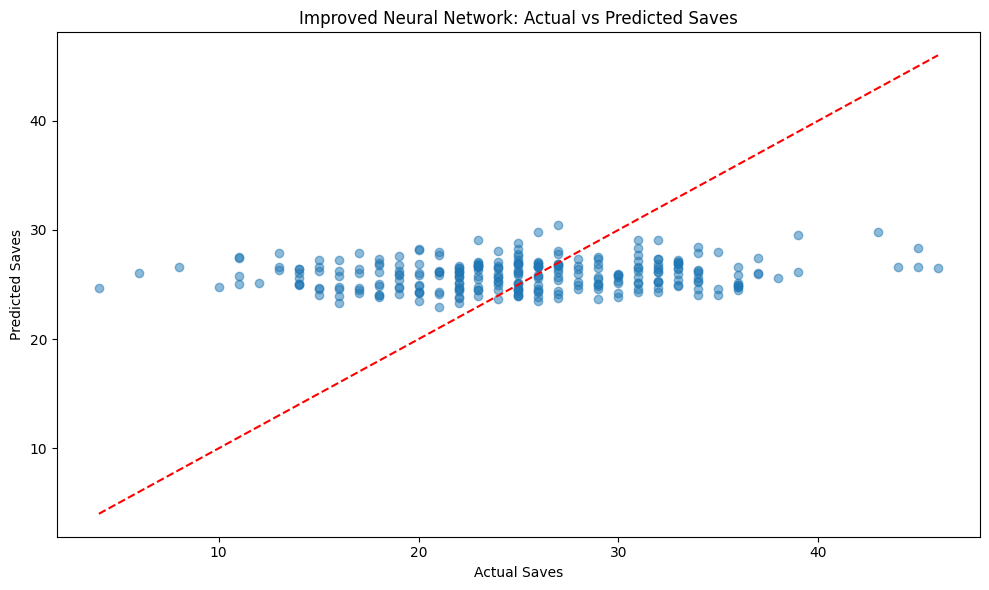

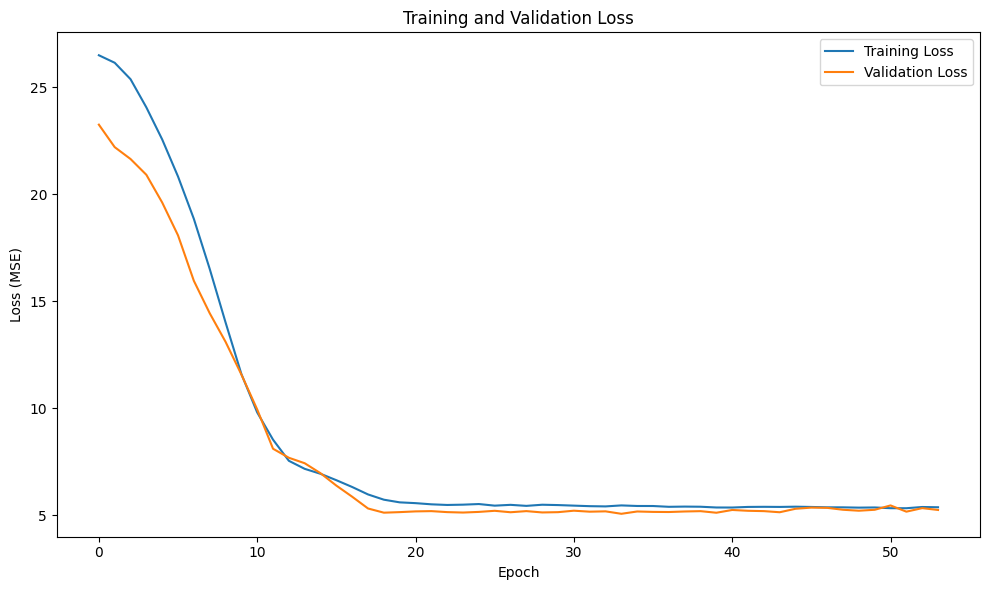


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0131
Mean Absolute Error: 5.6240 saves
Root Mean Squared Error: 7.0746 saves
Predictions within ±1 saves: 11.76%
Predictions within ±2 saves: 23.90%
Predictions within ±3 saves: 31.99%
Predictions within ±5 saves: 52.94%


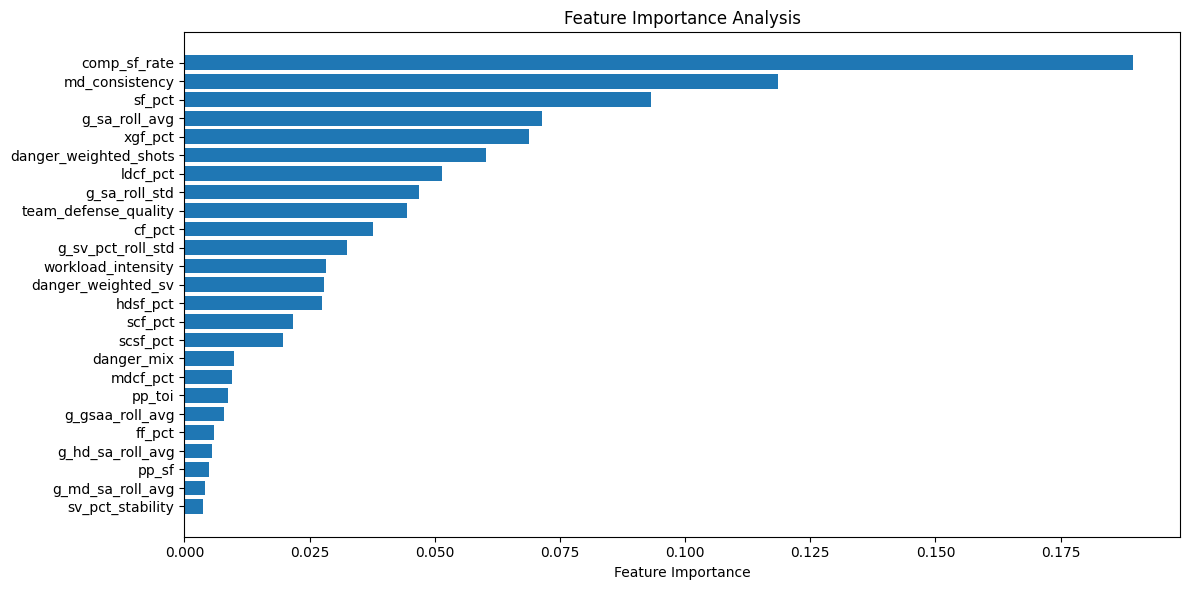


===== Creating Diverse Ensemble Model =====

===== Training Model 1: Standard Neural Network =====
Training neural network for 200 epochs...
Progress: [=====] 5/200 epochs - 1.1s elapsed, ~42.8s remaining
Train loss: 22.8288, Val loss: 17.4460, LR: 0.000564
Progress: [=====] 10/200 epochs - 2.2s elapsed, ~42.0s remaining
Train loss: 8.0529, Val loss: 5.0329, LR: 0.001043
Progress: [=====] 15/200 epochs - 3.3s elapsed, ~41.1s remaining
Train loss: 5.5629, Val loss: 5.2750, LR: 0.001806
Progress: [=====] 20/200 epochs - 4.4s elapsed, ~39.3s remaining
Train loss: 5.4950, Val loss: 5.1170, LR: 0.002801
Progress: [=====] 25/200 epochs - 5.5s elapsed, ~38.3s remaining
Train loss: 5.4217, Val loss: 5.2395, LR: 0.003959
Progress: [====
Early stopping triggered after 30 epochs

Training completed in 6.52 seconds

===== Training Model 2: Curriculum Learning =====
Setting up curriculum learning...
Starting curriculum training...
Progress: [] Epoch 0, Stage 1/4, Val Loss: 24.7121
Progress: [=] Ep

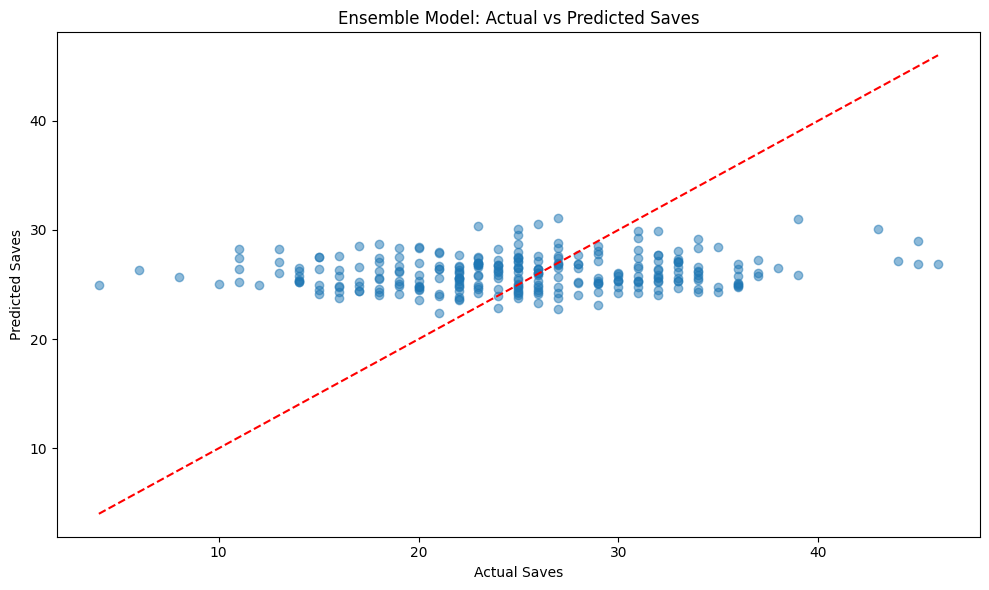


===== Single Model vs Ensemble Comparison =====
Single Model R²: 0.0131 | Ensemble R²: 0.0005
Single Model MAE: 5.6240 | Ensemble MAE: 5.6795
Single Model RMSE: 7.0746 | Ensemble RMSE: 7.1194


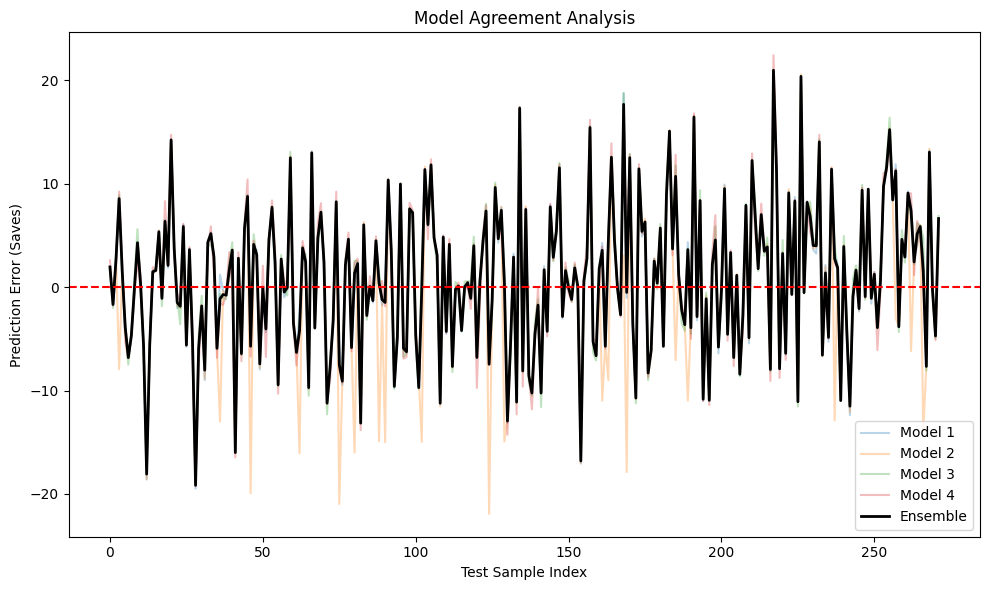


===== Final Model Performance Summary =====
Single Neural Network R²: 0.0131
Diverse Ensemble R²: 0.0005


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability and diagnose issues
import sys
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    # Try to force CUDA device
    try:
        test_tensor = torch.tensor([1.0]).cuda()
        print(f"Successfully created tensor on GPU: {test_tensor.device}")
    except Exception as e:
        print(f"Error when trying to use CUDA: {e}")
else:
    print("CUDA is not available. Possible reasons:")
    print("1. PyTorch was installed without CUDA support")
    print("2. NVIDIA drivers are not properly installed")
    print("3. Your GPU is not CUDA-compatible")
    print("4. CUDA toolkit version mismatch")
    
    # Check environment variables
    import os
    print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES", "Not set"))

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA benchmarking for performance optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

# Function to monitor GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Define a dataset class for our goalie data with GPU support
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define an improved neural network with residual connections
class ImprovedGoalieNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedGoalieNN, self).__init__()
        # Input normalization
        self.bn_input = nn.BatchNorm1d(input_size)
        
        # Wider network with residual connections
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        # Residual block 1
        self.res1_fc1 = nn.Linear(64, 64)
        self.res1_bn1 = nn.BatchNorm1d(64)
        self.res1_fc2 = nn.Linear(64, 64)
        self.res1_bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layers
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        # Input normalization
        x = self.bn_input(x)
        
        # Initial layers
        x = F.selu(self.bn1(self.fc1(x)))  # SELU activation
        x = self.dropout1(x)
        
        x = F.selu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Residual block 1
        residual = x
        x = F.selu(self.res1_bn1(self.res1_fc1(x)))
        x = self.res1_bn2(self.res1_fc2(x))
        x = F.selu(x + residual)  # Add residual connection
        
        # Final layers
        x = F.selu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.fc_out(x)

# Enhanced training function with GPU support and mixed precision
def train_nn_model_enhanced(X_train, y_train, X_test, y_test, 
                           batch_size=128, epochs=300, learning_rate=0.001,
                           weight_decay=1e-4, patience=20):
    """
    Enhanced training function with GPU support and mixed precision training
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = ImprovedGoalieNN(X_train.shape[1]).to(device)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Use AdamW optimizer for better weight decay handling
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add OneCycleLR scheduler for better convergence
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(train_loader)
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Use mixed precision for forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Scale the loss and call backward
            scaler.scale(loss).backward()
            
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Step and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            # Update learning rate
            scheduler.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Early stopping logic with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print_gpu_memory()  # Monitor GPU memory usage
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Test data is already on GPU from the dataset
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to implement curriculum learning
def train_with_curriculum(X_train, y_train, X_test, y_test, epochs=400):
    """
    Implement curriculum learning - start with easier examples and gradually
    introduce harder ones
    """
    # Start timing
    start_time = time.time()
    
    # Check if inputs are pandas objects and convert if needed
    is_pandas_x = hasattr(X_train, 'iloc')
    is_pandas_y = hasattr(y_train, 'iloc')
    
    # Convert to numpy if they're pandas objects
    X_train_np = X_train if not is_pandas_x else X_train.values
    y_train_np = y_train if not is_pandas_y else y_train.values
    
    # Calculate error proxy - use standard deviation of target within similar feature space
    from sklearn.neighbors import NearestNeighbors as KNN
    
    print("Setting up curriculum learning...")
    # Find 20 nearest neighbors for each sample
    neighbors = KNN(n_neighbors=20)
    neighbors.fit(X_train_np)
    distances, indices = neighbors.kneighbors(X_train_np)
    
    # Calculate standard deviation of target within neighbors
    difficulty = []
    for idx_list in indices:
        if is_pandas_y:
            difficulty.append(np.std(y_train.iloc[idx_list]))
        else:
            difficulty.append(np.std(y_train[idx_list]))
    
    # Sort by difficulty
    difficulty = np.array(difficulty)
    sorted_indices = np.argsort(difficulty)
    
    # Create curriculum stages (4 stages of increasing difficulty)
    stage_size = len(sorted_indices) // 4
    stages = [
        sorted_indices[:stage_size],                      # Easiest 25%
        sorted_indices[:stage_size*2],                    # Easiest 50%
        sorted_indices[:stage_size*3],                    # Easiest 75%
        sorted_indices                                    # All data
    ]
    
    print("Starting curriculum training...")
    # Train with curriculum
    model = ImprovedGoalieNN(X_train_np.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=1)
    
    # Initialize for early stopping
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0
    patience = 20
    
    # Training loop with curriculum
    print(f"Progress: [", end="")
    for epoch in range(epochs):
        model.train()
        
        # Determine which stage we're in
        stage_idx = min(epoch // (epochs // 4), 3)
        curr_indices = stages[stage_idx]
        
        # Create dataset for current stage - handle both pandas and numpy
        if is_pandas_x:
            X_curr = X_train.iloc[curr_indices].values
        else:
            X_curr = X_train_np[curr_indices]
            
        if is_pandas_y:
            y_curr = y_train.iloc[curr_indices].values
        else:
            y_curr = y_train_np[curr_indices]
        
        # Convert to tensors and move to device
        X_tensor = torch.tensor(X_curr, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_curr, dtype=torch.float32).reshape(-1, 1).to(device)
        
        # Forward and backward pass
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Validation every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Handle both pandas and numpy for test data
                if hasattr(X_test, 'values'):
                    X_test_np = X_test.values
                else:
                    X_test_np = X_test
                    
                if hasattr(y_test, 'values'):
                    y_test_np = y_test.values
                else:
                    y_test_np = y_test
                
                X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
                y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).reshape(-1, 1).to(device)
                outputs = model(X_test_tensor)
                val_loss = criterion(outputs, y_test_tensor).item()
                
                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                
                if early_stopping_counter >= patience // 10:  # Adjusted for checking every 10 epochs
                    print(f"\nEarly stopping triggered after {epoch+1} epochs")
                    break
                
                print(f"] Epoch {epoch}, Stage {stage_idx+1}/4, Val Loss: {val_loss:.4f}")
                print(f"Progress: [", end="")
        
        # Print progress
        if epoch % 10 == 0:
            print("=", end="", flush=True)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Handle both pandas and numpy for final evaluation
        if hasattr(X_test, 'values'):
            X_test_np = X_test.values
        else:
            X_test_np = X_test
            
        X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Get actual y_test values for metrics calculation
    if hasattr(y_test, 'values'):
        y_test_values = y_test.values
    else:
        y_test_values = y_test
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test_values, y_pred),
        'mae': mean_absolute_error(y_test_values, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test_values, y_pred))
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nCurriculum training completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to augment training data
def augment_training_data(X_train, y_train, augment_factor=0.3):
    """
    Augment training data with synthetic examples
    """
    print("Augmenting training data...")
    # Standardize for augmentation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Number of samples to generate
    n_augment = int(X_train.shape[0] * augment_factor)
    
    # Generate synthetic samples
    augmented_X = []
    augmented_y = []
    
    for _ in range(n_augment):
        # Randomly select a sample
        idx = np.random.randint(0, X_scaled.shape[0])
        sample_X = X_scaled[idx].copy()
        sample_y = y_train.iloc[idx]
        
        # Add random noise to features (small perturbations)
        noise = np.random.normal(0, 0.1, size=sample_X.shape)
        sample_X += noise
        
        # Add small random noise to target (realistic variation)
        target_noise = np.random.normal(0, 0.5)  # 0.5 saves standard deviation
        new_y = sample_y + target_noise
        
        augmented_X.append(sample_X)
        augmented_y.append(new_y)
    
    # Combine original and augmented data
    augmented_X = np.vstack([X_scaled, np.array(augmented_X)])
    augmented_y = np.concatenate([y_train.values, np.array(augmented_y)])
    
    # Inverse transform X back to original scale
    augmented_X = scaler.inverse_transform(augmented_X)
    
    print(f"Data augmented from {X_train.shape[0]} to {augmented_X.shape[0]} samples")
    return augmented_X, pd.Series(augmented_y)

# Function to create a diverse ensemble
def create_diverse_ensemble(X_train, y_train, X_test, y_test):
    """
    Create a more diverse ensemble with different architectures and training approaches
    """
    predictions = []
    
    print("\n===== Training Model 1: Standard Neural Network =====")
    model1, pred1, metrics1 = train_nn_model_enhanced(
        X_train, y_train, X_test, y_test,
        batch_size=128,
        epochs=200,
        learning_rate=0.001
    )
    predictions.append(pred1)
    
    print("\n===== Training Model 2: Curriculum Learning =====")
    model2, pred2, metrics2 = train_with_curriculum(
        X_train, y_train, X_test, y_test,
        epochs=200
    )
    predictions.append(pred2)
    
    print("\n===== Training Model 3: Neural Network with Augmented Data =====")
    X_aug, y_aug = augment_training_data(X_train, y_train)
    model3, pred3, metrics3 = train_nn_model_enhanced(
        X_aug, y_aug, X_test, y_test,
        batch_size=128,
        epochs=150
    )
    predictions.append(pred3)
    
    # Try to import tree-based models, but continue if not available
    try:
        print("\n===== Training Model 4: XGBoost =====")
        import xgboost as xgb
        xgb_model = xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        )
        xgb_model.fit(X_train, y_train)
        pred4 = xgb_model.predict(X_test)
        predictions.append(pred4)
        print(f"XGBoost R² Score: {r2_score(y_test, pred4):.4f}")
    except ImportError:
        print("XGBoost not available, skipping this model")
    
    try:
        print("\n===== Training Model 5: LightGBM =====")
        import lightgbm as lgb
        lgb_model = lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        )
        lgb_model.fit(X_train, y_train)
        pred5 = lgb_model.predict(X_test)
        predictions.append(pred5)
        print(f"LightGBM R² Score: {r2_score(y_test, pred5):.4f}")
    except ImportError:
        print("LightGBM not available, skipping this model")
    
    # Stack predictions and use median for final prediction
    predictions = np.column_stack(predictions)
    ensemble_pred = np.median(predictions, axis=1)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, ensemble_pred),
        'mae': mean_absolute_error(y_test, ensemble_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred))
    }
    
    print("\n===== Diverse Ensemble Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = ensemble_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return ensemble_pred, metrics, predictions

# Function to add advanced hockey-specific features
def add_advanced_hockey_features(X):
    """
    Add hockey-specific feature interactions and transformations
    """
    print("Adding advanced hockey-specific features...")
    
    # Make a copy to avoid modifying the original
    X_new = X.copy()
    
    # Goalie fatigue and rest impact (if these columns exist)
    if 'g_days_rest' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['fatigue_factor'] = np.exp(-X['g_days_rest'] / 3) * X['g_sa_roll_avg']
    
    # Save percentage stability (higher is better)
    if 'g_sv_pct_roll_std' in X.columns:
        X_new['sv_pct_stability'] = 1 / (X['g_sv_pct_roll_std'] + 0.001)
    
    # Danger zone effectiveness
    if all(col in X.columns for col in ['g_hdsv_pct_roll_avg', 'g_hd_sa_roll_avg', 
                                        'g_mdsv_pct_roll_avg', 'g_md_sa_roll_avg',
                                        'g_ldsv_pct_roll_avg', 'g_ld_sa_roll_avg']):
        X_new['danger_zone_effectiveness'] = (X['g_hdsv_pct_roll_avg'] * X['g_hd_sa_roll_avg'] + 
                                             X['g_mdsv_pct_roll_avg'] * X['g_md_sa_roll_avg'] + 
                                             X['g_ldsv_pct_roll_avg'] * X['g_ld_sa_roll_avg']) / (
                                             X['g_hd_sa_roll_avg'] + X['g_md_sa_roll_avg'] + X['g_ld_sa_roll_avg'] + 0.001)
    
    # Team defense quality
    if all(col in X.columns for col in ['cf_pct', 'scf_pct']):
        X_new['team_defense_quality'] = X['cf_pct'] * X['scf_pct']
        if 'hdcf_pct' in X.columns:
            X_new['team_defense_quality'] *= X['hdcf_pct']
    
    # Expected save differential (how goalie performs vs expectation)
    if 'g_gsaa_roll_avg' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['expected_save_diff'] = X['g_gsaa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Consistency metrics
    if 'g_hdsv_pct_roll_std' in X.columns:
        X_new['hd_consistency'] = 1 / (X['g_hdsv_pct_roll_std'] + 0.001)
    if 'g_mdsv_pct_roll_std' in X.columns:
        X_new['md_consistency'] = 1 / (X['g_mdsv_pct_roll_std'] + 0.001)
    if 'g_ldsv_pct_roll_std' in X.columns:
        X_new['ld_consistency'] = 1 / (X['g_ldsv_pct_roll_std'] + 0.001)
    
    # Danger weighted save percentage
    if all(col in X.columns for col in ['g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg', 'g_ldsv_pct_roll_avg']):
        X_new['danger_weighted_sv'] = (X['g_hdsv_pct_roll_avg'] * 3 + 
                                      X['g_mdsv_pct_roll_avg'] * 2 + 
                                      X['g_ldsv_pct_roll_avg']) / 6
    
    # Danger weighted shots
    if all(col in X.columns for col in ['g_hd_sa_roll_avg', 'g_md_sa_roll_avg', 'g_ld_sa_roll_avg']):
        X_new['danger_weighted_shots'] = (X['g_hd_sa_roll_avg'] * 3 + 
                                         X['g_md_sa_roll_avg'] * 2 + 
                                         X['g_ld_sa_roll_avg']) / 6
    
    # High-danger to low-danger ratio
    if 'g_hd_sa_roll_avg' in X.columns and 'g_ld_sa_roll_avg' in X.columns:
        X_new['hd_ld_ratio'] = X['g_hd_sa_roll_avg'] / (X['g_ld_sa_roll_avg'] + 0.001)
    
    # Save percentage consistency
    if 'g_sv_pct_roll_avg' in X.columns and 'g_sv_pct_roll_std' in X.columns:
        X_new['sv_consistency'] = X['g_sv_pct_roll_avg'] / (X['g_sv_pct_roll_std'] + 0.001)
    
    # Expected goals efficiency
    if 'g_gsaa_roll_avg' in X.columns and 'g_xg_against_roll_avg' in X.columns:
        X_new['xg_efficiency'] = X['g_gsaa_roll_avg'] / (X['g_xg_against_roll_avg'] + 0.001)
    
    # Special teams effect
    if all(col in X.columns for col in ['pp_toi', 'pp_pdo', 'pk_toi', 'pk_pdo']):
        X_new['special_teams_effect'] = X['pp_toi'] * X['pp_pdo'] - X['pk_toi'] * X['pk_pdo']
    
    # Workload intensity
    if 'g_sa_roll_avg' in X.columns and 'g_xg_against_roll_avg' in X.columns:
        X_new['workload_intensity'] = X['g_sa_roll_avg'] * X['g_xg_against_roll_avg']
    
    # Danger mix
    if 'g_hd_sa_roll_avg' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['danger_mix'] = X['g_hd_sa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Create polynomial features for key metrics
    if 'g_gsaa_roll_avg' in X.columns:
        X_new['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    if 'g_sv_pct_roll_avg' in X.columns:
        X_new['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    print(f"Added {len(X_new.columns) - len(X.columns)} new features")
    return X_new
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with enhanced feature engineering
    """
    # Define base features using the new feature set
    base_features = [
        'sf_pct', 'comp_sf_rate', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg',
        'scsh_pct', 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std',
        'pp_sh_pct', 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std',
        'g_xg_against_roll_avg', 'g_md_sa_roll_avg', 'g_md_sa_roll_std',
        'g_xg_against_roll_std', 'g_gsaa_roll_std', 'ldcf_pct',
        'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg', 'pp_sf', 'pp_pdo',
        'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct', 'g_mdsv_pct_roll_std',
        'g_gaa_roll_std', 'g_hdsv_pct_roll_avg', 'g_gaa_roll_avg',
        'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
        'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg',
        'mdcf_pct', 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct',
        'g_ldsv_pct_roll_avg', 'g_sv_pct_roll_avg', 'ldsv_pct',
        'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca', 'mdsv_pct',
        'xgf_pct', 'toi', 'pk_ldca'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Add advanced hockey-specific features
    X = add_advanced_hockey_features(X)
    
    # Handle missing values with more sophisticated approach
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            # For percentage columns, fill with median
            if 'pct' in col or col.endswith('_pct'):
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())
    
    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)
    
    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Improved feature selection using a combination of methods
    # Use both mutual information and F-test for feature selection
    k = min(25, X_train.shape[1])  # Increase from 20 to 25 features
    
    # Mutual information selector
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_scores = mi_selector.fit(X_train, y_train).scores_
    
    # F-test selector
    f_selector = SelectKBest(f_regression, k=k)
    f_scores = f_selector.fit(X_train, y_train).scores_
    
    # Combine scores (normalize first)
    mi_scores = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-10)
    f_scores = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-10)
    combined_scores = mi_scores + f_scores
    
    # Select top features based on combined score
    top_indices = np.argsort(combined_scores)[-k:]
    
    # Get selected features
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    selected_features = X_train.columns[top_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    # Scale features with RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Train the neural network with enhanced settings
    print("\n===== Training Single Neural Network =====")
    model, y_pred, metrics = train_nn_model_enhanced(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=128,  # Larger batch size for GPU
        epochs=300,
        learning_rate=0.001,
        weight_decay=1e-4,
        patience=20
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis using sensitivity analysis
    feature_importance = []
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        baseline = model(X_test_tensor).cpu().numpy().flatten()
        for i in range(X_test_scaled.shape[1]):
            # Perturb each feature and measure the effect
            X_perturbed = X_test_scaled.copy()
            X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
            X_perturbed_tensor = torch.tensor(X_perturbed, dtype=torch.float32).to(device)
            perturbed = model(X_perturbed_tensor).cpu().numpy().flatten()
            importance = np.mean(np.abs(perturbed - baseline))
            feature_importance.append(importance)
    
    # Normalize importances
    feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create diverse ensemble model
    print("\n===== Creating Diverse Ensemble Model =====")
    ensemble_pred, ensemble_metrics, all_predictions = create_diverse_ensemble(
        X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Plot ensemble predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, ensemble_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Ensemble Model: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Compare single model vs ensemble
    print("\n===== Single Model vs Ensemble Comparison =====")
    print(f"Single Model R²: {metrics['r2_score']:.4f} | Ensemble R²: {ensemble_metrics['r2_score']:.4f}")
    print(f"Single Model MAE: {metrics['mae']:.4f} | Ensemble MAE: {ensemble_metrics['mae']:.4f}")
    print(f"Single Model RMSE: {metrics['rmse']:.4f} | Ensemble RMSE: {ensemble_metrics['rmse']:.4f}")
    
    # Analyze model agreement
    if all_predictions.shape[1] > 1:
        plt.figure(figsize=(10, 6))
        for i in range(all_predictions.shape[1]):
            plt.plot(all_predictions[:, i] - y_test.values, alpha=0.3, label=f'Model {i+1}')
        plt.plot(ensemble_pred - y_test.values, 'k-', linewidth=2, label='Ensemble')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Prediction Error (Saves)')
        plt.title('Model Agreement Analysis')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return {
        'single_model': model,
        'ensemble_pred': ensemble_pred,
        'scaler': scaler,
        'single_metrics': metrics,
        'ensemble_metrics': ensemble_metrics,
        'selected_features': selected_features,
        'all_predictions': all_predictions
    }

# Run the improved neural network model
try:
    results = run_improved_goalie_nn()
    
    # Print final summary
    print("\n===== Final Model Performance Summary =====")
    print(f"Single Neural Network R²: {results['single_metrics']['r2_score']:.4f}")
    print(f"Diverse Ensemble R²: {results['ensemble_metrics']['r2_score']:.4f}")
    
    # Save the best model if requested
    save_model = input("Do you want to save the best model? (y/n): ")
    if save_model.lower() == 'y':
        import pickle
        
        # Determine which model to save
        if results['ensemble_metrics']['r2_score'] > results['single_metrics']['r2_score']:
            model_data = {
                'type': 'ensemble',
                'predictions': results['all_predictions'],
                'scaler': results['scaler'],
                'selected_features': results['selected_features']
            }
            filename = 'goalie_ensemble_model.pkl'
        else:
            model_data = {
                'type': 'single',
                'model': results['single_model'],
                'scaler': results['scaler'],
                'selected_features': results['selected_features']
            }
            filename = 'goalie_single_model.pkl'
        
        # Save the model
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved as {filename}")
        
except Exception as e:
    print(f"An error occurred during model training: {e}")
    import traceback
    traceback.print_exc()